# Q1. Finding Similar Customers

## Installing Libraries

In [1]:
%%capture
import os
os.system("pip install wget")
import wget
import gdown
import zipfile

from sortedcontainers import SortedSet, SortedDict
from typing import Dict, Tuple, Iterable, Set, List, Union, Any
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import random
import csv

import scipy.integrate as integrate

## Download the [Kaggle Dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) that we have saved on a S3 Bucket:

In [2]:
def download_zip(url: str) -> None:
  """A function that we'll use to download our files saved on our S3.
  The function works with any type of url.

  Args:
    - url (str): The url where the file is saved.

  Return:
    - None
  """
  print(f"Downloading from {url},", end=" ")
  try:
    filename = wget.download(url)
  except Exception as e:
    print("failed")
    print(e)
  else:
    print("done.")
    print(f"File saved in /content/{filename}")

    if filename.split(".")[-1] == "zip":
      with zipfile.ZipFile(filename, "r") as zip_ref:
        print(f"Unzipping {filename},", end=" ")
        zip_ref.extractall()
        print("done.")
        os.remove(f"/content/{filename}")

In [3]:
download_zip("https://adm-hw4-mep27.s3.amazonaws.com/bank_segmentation.zip")

File saved in /content/bank_segmentation.zip
Unzipping bank_segmentation.zip, done.


In [4]:
df = pd.read_csv("bank_transactions.csv")

## Setting the `TransactionDate` variables to a `datatime` format and displaying the head of the dataframe.

In [5]:
df["TransactionDate"] =  pd.to_datetime(df['TransactionDate'])

df.set_index("CustomerID", inplace=True)

display(df.head())

TransactionID CustomerDOB CustGender CustLocation  \
CustomerID                                                     
C5841053              T1     10/1/94          F   JAMSHEDPUR   
C2142763              T2      4/4/57          M      JHAJJAR   
C4417068              T3    26/11/96          F       MUMBAI   
C5342380              T4     14/9/73          F       MUMBAI   
C9031234              T5     24/3/88          F  NAVI MUMBAI   

            CustAccountBalance TransactionDate  TransactionTime  \
CustomerID                                                        
C5841053              17819.05      2016-02-08           143207   
C2142763               2270.69      2016-02-08           141858   
C4417068              17874.44      2016-02-08           142712   
C5342380             866503.21      2016-02-08           142714   
C9031234               6714.43      2016-02-08           181156   

            TransactionAmount (INR)  
CustomerID                           
C5841053                       25.0  
C2142763                    27999.0  
C4417068                      459.0  
C5342380                     2060.0  
C9031234                     1762.5

## Taking only the needed columns

We have defined as similiar the customers that have a similar backing scheme in terms of `CustAccountBalance` and `TransactionDate`.

For this reason we preserve as columns:

- CustomerID
- CustAccountBalance
- TransactionDate
- TransactionAmount (INR)

We order the dataframe for `CustomerID` and each customer transactions for `TransactionDate`.

In [6]:
reduced_df = df[["CustAccountBalance", "TransactionDate", "TransactionAmount (INR)"]]\
.sort_values(["CustomerID", "TransactionDate"], ascending=["True", "False"])\

display(reduced_df.head())

CustAccountBalance TransactionDate  TransactionAmount (INR)
CustomerID                                                             
C1010011             120180.54      2016-09-08                    356.0
C1010011              32500.73      2016-09-26                   4750.0
C1010012              24204.49      2016-08-14                   1499.0
C1010014              38377.14      2016-01-08                   1205.0
C1010014             161848.76      2016-07-08                    250.0

Some customers have more than one transaction, to handle this we decided to compute a new dataframe which we'll refer to as the `descriptive_dataframe`.
On this particular dataframe we store for each `CustomerID` the descriptive statistics of its `CustAccountBalance` (mean, variance) and `TransactionAmount (INR)` (mean, varinace, sum, count).

In [7]:
def descriptive_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
  """Creates a pd.DataFrame which has the descriptive statistics for AccountBalance and TransactionAmount (INR).

  Args:
    - dataframe (pd.DataFrame): A pd.DataFrame on which the result is built.

  Return:
    - result (pd.DataFrame): The descriptive pd.DataFrame.
  """
  balance_insight = dataframe\
                    .groupby('CustomerID')["CustAccountBalance"]\
                    .agg(["mean", "var"])
                    
  balance_insight["var"].fillna(0, inplace=True)
  balance_insight.columns = ["BalanceMean", "BalanceVar"]

  print("Display for the balance insights:")
  display(balance_insight.head())


  transactions_insight = dataframe\
                         .groupby('CustomerID')['TransactionAmount (INR)']\
                         .agg(['sum', 'mean', 'var', 'count'])

  transactions_insight["var"].fillna(0, inplace=True)
  transactions_insight.columns = ["TransactionsSum", "TransactionsMean", "TransactionsVar", "NumTransactions"]

  print()
  print("Display for the transactions insights:")
  display(transactions_insight.head())

  result = balance_insight.join(transactions_insight, on="CustomerID")

  print()
  print("The combined dataframe:")
  display(result.head())

  return result

We chunck the values in steps, in this way we "discretize" the values following the idea that:

>Words of same lenght that have different character are more luckly to be different, while for number this is not true.

Example:

If we take into account three customers whose ballance_mean are of 678, 595 and 1678, even if the first two numbers are different in terms of characters, they are more similar in a backing point of view (both ballance less than 1000) than with the third one which has more characters in common with the first one, but for a backing point of view is much different.

For this reason we decided to add as feature the magnitude for mean, sum and variance (we replace the actual variance for its magnitude) and we step each mean and sum to steps of 500.

In [8]:
def round_avg_sum(x: float,
                  near: int = 1):
  """A function that rounds a given number near a specific number.

  Args:
    - x (float): The number to round up.
    - near (int): The number to use to manage where to round up. Default 1. 
  
  Returns:
    - result (int): The rounded number.
  """
  if x/near - int(x//near) < 0.5:
    result = int(x//near)*near
  else:
    result = int(x//near+1)*near

  return result

def round_variance(x: float):
  """A function that rounds the variance to its order of magnitude

  Args:
    - x (float): The number to round up. It is expected to be not negative.

  Returns:
    - int : The order of magnitude of the input.
  """  
  if int(str(x)[0])>= 5:
   result = round_avg_sum(math.log(x+1, 10))+1
  else:
    result = round_avg_sum(math.log(x+1, 10))

  return result

In [9]:
aggregate_df = descriptive_dataframe(reduced_df)

aggregate_df.dropna(inplace=True)

Display for the balance insights:


BalanceMean    BalanceVar
CustomerID                           
C1010011      76340.635  3.843875e+09
C1010012      24204.490  0.000000e+00
C1010014     100112.950  7.622620e+09
C1010018        496.180  0.000000e+00
C1010024      87058.650  0.000000e+00


Display for the transactions insights:


TransactionsSum  TransactionsMean  TransactionsVar  \
CustomerID                                                       
C1010011             5106.0            2553.0        9653618.0   
C1010012             1499.0            1499.0              0.0   
C1010014             1455.0             727.5         456012.5   
C1010018               30.0              30.0              0.0   
C1010024             5000.0            5000.0              0.0   

            NumTransactions  
CustomerID                   
C1010011                  2  
C1010012                  1  
C1010014                  2  
C1010018                  1  
C1010024                  1


The combined dataframe:


BalanceMean    BalanceVar  TransactionsSum  TransactionsMean  \
CustomerID                                                                 
C1010011      76340.635  3.843875e+09           5106.0            2553.0   
C1010012      24204.490  0.000000e+00           1499.0            1499.0   
C1010014     100112.950  7.622620e+09           1455.0             727.5   
C1010018        496.180  0.000000e+00             30.0              30.0   
C1010024      87058.650  0.000000e+00           5000.0            5000.0   

            TransactionsVar  NumTransactions  
CustomerID                                    
C1010011          9653618.0                2  
C1010012                0.0                1  
C1010014           456012.5                2  
C1010018                0.0                1  
C1010024                0.0                1

In [10]:
def preprocess_dataframe(dataframe: pd.DataFrame,
                         step: int = 500) -> pd.DataFrame:
  """The function used to do the preprocessing (discretization) of the values.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame we want to preprocess.
    - step (int): The step of discretization. Default 500.

  Returns:
    - df (pd.DataFrame) : A preprocessed pd.DataFrame.
  """
  df = pd.DataFrame()

  df["BalanceVar"] = dataframe["BalanceVar"].apply(lambda x: round_variance(x))
  df["TransactionsVar"] = dataframe["TransactionsVar"].apply(lambda x: round_variance(x))

  df["BalanceMean"] = dataframe["BalanceMean"].apply(lambda x: round_avg_sum(x, step)) 
  df["TransactionsSum"] = dataframe["TransactionsSum"].apply(lambda x: round_avg_sum(x, step)) 
  df["TransactionsMean"] = dataframe["TransactionsMean"].apply(lambda x: round_avg_sum(x, step))

  df["BalanceMeanMagnitude"] = dataframe["BalanceMean"].apply(lambda x: round_variance(x))
  df["TransactionsSumMagnitude"] = dataframe["TransactionsSum"].apply(lambda x: round_variance(x)) 
  df["TransactionsMeanMagnitude"] = dataframe["TransactionsMean"].apply(lambda x: round_variance(x))

  df["NumTransactions"] = dataframe["NumTransactions"]

  display(df.head())

  return df

In [11]:
step = 500

prep_df = preprocess_dataframe(aggregate_df, step)

BalanceVar  TransactionsVar  BalanceMean  TransactionsSum  \
CustomerID                                                              
C1010011            10                8        76500             5000   
C1010012             0                0        24000             1500   
C1010014            11                6       100000             1500   
C1010018             0                0          500                0   
C1010024             0                0        87000             5000   

            TransactionsMean  BalanceMeanMagnitude  TransactionsSumMagnitude  \
CustomerID                                                                     
C1010011                2500                     6                         5   
C1010012                1500                     4                         3   
C1010014                 500                     5                         3   
C1010018                   0                     3                         1   
C1010024                5000                     6                         5   

            TransactionsMeanMagnitude  NumTransactions  
CustomerID                                              
C1010011                            3                2  
C1010012                            3                1  
C1010014                            4                2  
C1010018                            1                1  
C1010024                            5                1

## Grouping similar customers using LSH

### Create the shingles

The idea is to create a dictionary in which for each customer (the key) we save a SOrtedSet containing the tuples (column_name, column_value), in this way for a general customer $i$ we have:


```
customer_i = [('BalanceVar', value), ..., ('NumTransactions', value)]
```

In this way we preserve the sense of the value (which dimension it is refered to).

To mantain this "index" we have created a special class that we have called `Shingles()`.



In [12]:
class Shingles():
  """A class to create and maintain the shingles.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame on which we build the shingles. Default None.
    - n_shingles (int): The total number of contained shingles. Default 0.
    - shingles_index (Dict[Tuple[str, int], int]): A dictionary which keys are the shingles and the values their id. Default empty Dict.
    - index_to_shingle (Dict[int, Tuple[str, int]]): A dictionary which keys are the id of the shingles and the values are the shingles it-self. Default empty Dict.
    - n_customers (int): The total number of contained customers. Default 0.
    - customers_index (Dict[str, int]): A dictionary which keys are the customers and the values their id. Default empty Dict.
    - index_to_customer (Dict[int, str]): A dictionary which keys are the id of the customers and the values are the customers it-self. Default empty Dict.
    - docs_to_shingles (Dict[int, SortedSet]): A dictionary that has as keys the documents id and as values the word id of each word contained in that document.
                                               For document we refer to a customer, and the word to the shingle. Default empty Dict.
    - query_shingles (Dict[int, SortedSet]): A dictionary equal to docs_to_shingles but only for query documents.

  Attributes:
    - __n_shingles (int): The private variable where we store the attribute n_shingles.
    - __shingles_index (Dict[Tuple[str, int], int]): The private variable where we store the attribute shingles_index.
    - __index_to_shingle (Dict[int, Tuple[str, int]]): The private variable where we store the attribute index_to_shingle.
    - __n_customers (int): The private variable where we store the attribute n_customers.
    - __customers_index (Dict[str, int]): The private variable where we store the attribute customers_index.
    - __index_to_customer (Dict[int, str]): The private variable where we store the attribute index_to_customer.
    - __docs_to_shingles (Dict[int, SortedSet()]): The private variable where we store the attribute docs_to_shingles.
    - __query_shingles (Dict[int, SortedSet()]): The private variable where we store the attribute query_shingles.
  """
  
  def __init__(self,
               dataframe: pd.DataFrame = None,
               n_shingles: int = 0,
               shingles_index: Dict[Tuple[str, int], int] = {},
               index_to_shingle: Dict[int, Tuple[str, int]] = {},
               n_customers: int = 0,
               customers_index: Dict[str, int] = {},
               index_to_customer: Dict[int, str] = {},
               docs_to_shingles: Dict[int, SortedSet] = {},
               query_shingles: Dict[int, SortedSet] = {}):
    
    self.__n_shingles = n_shingles
    self.__shingles_index = shingles_index
    self.__index_to_shingle = index_to_shingle

    self.__n_customers = n_customers
    self.__customers_index = customers_index
    self.__index_to_customer = index_to_customer

    self.__docs_to_shingles = docs_to_shingles

    self.__query_shingles = query_shingles

    if dataframe is not None:
      self.__add_to_indexes(dataframe)

  def __len__(self) -> int:
    """An override of the __len__ method.

    Returns:
      - int : The total number of shingles.
    """
    return self.__n_shingles

  def __str__(self) -> str:
    """An override of the __str__ method.

    Returns:
      - str : A descriptive string of the class.
    """
    return f"Number of shingles: {self.__n_shingles}.\nNumber of customers: {self.__n_customers}."

  def __get_add__shingle_id(self,
                            shingle: Tuple[str, int]) -> int:
    """A private method to get a shingle_id given a shingle.
    If the shingle is not in the shingles index then we add it.

    Args:
      - shingle (Tuple[str, int]): The shingle of which we want the id.

    Returns:
      - int : The id of the shingle.
    """
    id = self.__shingles_index.get(shingle, 0)

    if id:
      return id

    self.__shingles_index[shingle] = self.__n_shingles
    self.__index_to_shingle[self.__n_shingles] = shingle

    self.__n_shingles += 1

    return self.__n_shingles-1

  def get__n_shingles(self) -> int:
    """It returns the maximum index for the shingles.

    Returns:
      - int : The maximum idec for the shingles.
    """
    return self.__n_shingles

  def get__shingle_id(self,
                      shingle: Tuple[str, int]) -> int:
    """A public method to get a shingle_id given a shingle.

    Args:
      - shingle (Tuple[str, int]): The shingle of which we want the id.

    Returns:
      - id (int): The id of the shingle.
    """
    assert isinstance(shingle, tuple), f"Error: shingle type should a Tuple[str, int], got a {type(shingle)}."

    try:
      id = self.__shingles_index[shingle]
    except:
      raise Exception(f"Error: shingle '{shingle}' not found.")

    return id

  def get__shingle(self,
                   id: int) -> Tuple[str, int]:
    """A public method to retrieve a shingle given its id.

    Args:
      - id (int): The shingle_id.

    Returns:
      - shingle (Tuple[str, int]): The corresponding shingle.
    """
    assert isinstance(id, int), f"Error: id type should be int, got a {type(id)}."

    try:
      shingle = self.__index_to_shingle[id]
    except:
      raise Exception(f"Error: id '{id}' not found.")

    return shingle

  def get__shingles_id(self) -> List[int]:
    """A fucntion that returns all the shingles id.

    Returns:
      - List[int] : The list of shingles id
    """
    return list(self.__shingles_to_docs.keys())

  def __get_add__customer_id(self,
                             customer: str) -> int:
    """A private method to get a customer_id given a customer.
    If the customer is not in the customers index then we add it.

    Args:
      - customer (str): The customer of which we want the id.

    Returns:
      - int : The id of the customer.
    """
    id = self.__customers_index.get(customer, 0)

    if id:
      return id

    self.__customers_index[customer] = self.__n_customers
    self.__index_to_customer[self.__n_customers] = customer

    self.__n_customers += 1

    return self.__n_customers-1

  def get__n_customers(self) -> int:
    """It returns the maximum index for the customers.

    Returns:
      - int : The maximum idec for the customers.
    """
    return self.__n_customers

  def get__customer_id(self,
                       customer: str) -> int:
    """A public method to get a customer_id given a customer.

    Args:
      - customer (str): The customer of which we want the id.

    Returns:
      - id (int): The id of the customer.
    """

    try:
      id = self.__customers_index[customer]
    except:
      raise Exception(f"Error: customer '{customer}' not found.")

    return id

  def get__customer(self,
                    id: int) -> str:
    """A public method that retrieves the customer given its id.

    Args:
      - id (int): The customer id.

    Returns:
      - customer (str): The corresponding customer.
    """
    assert isinstance(id, int), f"Error: id type should be int, got a {type(id)}."

    try:
      customer = self.__index_to_customer[id]
    except:
      raise Exception(f"Error: id '{id}' not found.")

    return customer

  def get__customers_id(self) -> List[int]:
    """A function that returns a list of the customers id.

    Returns:
      - List[int] : The list of custumers id.
    """
    return list(self.__docs_to_shingles.keys())

  def get__customer_shingles(self,
                             customer: Union[str, int]) -> SortedSet:
    """Get the shingle set of a specific customer.

    Args:
      - customer (Union[str, int]): A customer name or id.

    Returns:
      - shingles (SortedSet): The SortedSet of shingles of that customer.
    """
    if isinstance(customer, str):
      try:
        id = self.get__customer_id(customer)
      except:
        raise Exception(f"Error: customer '{customer}' not found.")
      else:
        shingles = self.__docs_to_shingles[id]
    elif isinstance(customer, int):
      try:
        shingles = self.__docs_to_shingles[customer]
      except:
        raise Exception(f"Error: id '{customer}' not found.")
    else:
      raise Exception(f"Expected a str or an int as input, {type(customer)} was given.")

    return shingles

  def __add_to_indexes(self,
                       dataframe: pd.DataFrame) -> None:
    """A function that populates docs_to_shingles and shingles_to_docs, given a dataframe.

    Args:
      - dataframe (pd.DataFrame): The pd.DataFrame on which we want to build our indexes.

    Returns:
      - None
    """

    print("Populating the Shingle object...")
    for customer in tqdm(dataframe.index):

        customer_id = self.__get_add__customer_id(customer)
        self.__docs_to_shingles[customer_id] = SortedSet()

        for word in set(zip(dataframe.loc[customer].index, dataframe.loc[customer])):

          word_id = self.__get_add__shingle_id(word)
          self.__docs_to_shingles[customer_id].add(word_id)

    return None

  def add_query_shingles(self,
                         dataframe: pd.DataFrame) -> List[int]:
    """We add new shingles to our Shingles object.

    Args:
      - dataframe (pd.DataFrame): The pd.DataFrame containing the new customers and shingles.

    Returns:
      - List[int] : The list of query customers id.
    """
    n = self.__n_customers

    print("Populating the Shingle object...")
    for customer in tqdm(dataframe.index):

        customer_id = self.__get_add__customer_id(customer)
        self.__query_shingles[customer_id] = SortedSet()

        for word in set(zip(dataframe.loc[customer].index, dataframe.loc[customer])):

          word_id = self.__get_add__shingle_id(word)
          self.__query_shingles[customer_id].add(word_id)

    return list(range(n, n+len(dataframe)))

  def get__query_customer__shingles(self,
                                    customer_id: int,
                                    id: bool = True) -> SortedSet:
    """Given the customer id of a query customer, this functions returns its shingles.

    Args:
      - customer_id (int): The id of the customer.
      - id (bool): Defines if the customer_id passed as input is indeed a customer di or a customer. Default True.

    Returns:
      - The shingles of that customer.
    """

    if not id:
      try:
        customer_id = self.get__customer_id(customer_id)
      except:
        raise Exception(f"Customer '{customer_id}' not found.")

    try:
      shingles = self.__query_shingles[customer_id]
    except:
      raise Exception(f"Customer id '{customer_id}' not found.")

    return shingles

  def save(self,
            path: str) -> None:
      """To save an Index in a given path.

      Args:
        - path (str): The path where the index is going to be saved.

      Returns:
        - None
      """
      dump(self, path)
      return None

  @classmethod
  def loader(self,
             path: str) -> None:
    """The loader method used to load a saved Shingles object.

    Args:
      - path (str): The path where the file to load is stored.

    Returns:
      - Shingles : A Shingles object.
    """
    return load(path)

We can now create the shingles by intializing a `Shingles` object:

```python
shingles = Shingles(prep_df)
```

This takes around 3 or 4 minutes... to save this time we have performed it in advance and saved the result as a file.pkl:

```python
shingles.save("shingles.pkl")
```
Then we have zipped and store the result on a S3 bucket, so we can directly download it from there and load it:



In [13]:
download_zip("https://adm-hw4-mep27.s3.amazonaws.com/shingles.zip")

File saved in /content/shingles.zip
Unzipping shingles.zip, done.


### Minhashing

- `is_prime()`: Check if the passed number is prime or not.
- `create_hash_functions()`: It creates `n` hash functions.
- `min_wise_hashing__sketch()`: It computes the MinWiseHashing sketch of a shingle set.
- `create__min_wise_hashing__sketches()`: It computes `min_wise_hashing__sketch()` for each customer.

In [14]:
def is_prime(number):
  """Check if a number is prime or not.

  Args:
    - number (int): The number to check.

  Returns:
    - bool : True if the number is indeed prime, else False.
  """
  if number == 2:
      return True
  if (number % 2) == 0:
      return False
  for j in range(3, int(number ** 0.5 + 1), 2):
      if (number % j) == 0:
          return False
  return True

def create_hash_functions(n: int,
                          upper_bound,
                          seed: int = 42):
  """Create n modular hash functions -> h(x) = (a*x + b) mod p .

  Args:
    - n (int): Number of hash functions to create.
    - upper_bound (int): The limit on the variables.
    - seed (int): The seed for the random functions. Default 42.

  Returns:
    - Dict[int, Tuple[int]] : A dictionary that has as keys the number id of the specific hash function,
                              and as values the tuple (a, b, p)
  """
  random.seed(seed)

  functions = {}

  functions_set = set()
  while len(functions_set) < n:
      a = random.randint(1, upper_bound - 1)
      b = random.randint(0, upper_bound - 1)
      p = random.randint(upper_bound, 10 * upper_bound)
      while is_prime(p) == False:
          p = random.randint(upper_bound, 10 * upper_bound)

      functions_set.add((a, b, p))

  for id, values in enumerate(functions_set):
      functions[id] = values

  return functions

def min_wise_hashing__sketch(shingle_set: SortedSet,
                             hash_functions: List[Tuple[int]]) -> List[int]:
  """Given a shingle set and a List of hash functions parameters,
  this function will return the MinWiseHashing sketch of that shingle set.

  Args:
    - shingle_set (SortedSet): A shingle set.
    - hash_functions (List[Tuple[int]]): A list of hash functions parameters.

  Returns:
    - mwh_sketch (List[int]): The MinWiseHashing sketch for the shingle set passed as input.
  """
  mwh_sketch = [float("+inf")] * len(hash_functions)

  for shingle_id in shingle_set:
    index = -1
    for a, b, p in hash_functions:

      index += 1
      hashed_value = (a * shingle_id + b) % p
  
      if hashed_value < mwh_sketch[index]:
        mwh_sketch[index] = hashed_value

  return mwh_sketch

def create__min_wise_hashing__sketches(shingles: Shingles,
                                       n_hash_functions: int,
                                       customers_id: List[int] = None,
                                       seed: int = 42) -> SortedDict:
  """Given a Shingles object and a number of hash functions, it returns the MinWiseHashing sketch for each document.

  Args:
    - shingles (Shingles): The Shingles object.
    - n_hash_functions (int): The number of hash functions.
    - customers_id (List[int]): Subsample of the customers id of the Shingle object.
    - seed (int): The seed used in create_hash_functions(). Default 42.

  Returns:
    - min_wise_hashing__sketches (SortedDict): A dictionary that has as keys the documents id and as values the corresponding MinWiseHashing sketch.
  """
  hash_functions = list(create_hash_functions(n_hash_functions, len(shingles), seed).values())

  min_wise_hashing__sketches = SortedDict()

  if customers_id is None:
    customers_id = shingles.get__customers_id()

    for customer_id in tqdm(customers_id):
      min_wise_hashing__sketches[customer_id] = min_wise_hashing__sketch(shingle_set=shingles.get__customer_shingles(customer_id),
                                                                        hash_functions=hash_functions)
  else:
    for customer_id in tqdm(customers_id):
      min_wise_hashing__sketches[customer_id] = min_wise_hashing__sketch(shingle_set=shingles.get__query_customer__shingles(customer_id),
                                                                        hash_functions=hash_functions)

  return min_wise_hashing__sketches

### Locality-Sensitive Hashing

We define our implementation of the Jaccard Similarity:

In [15]:
def jaccard_similarity(a: Set[Any],
                       b: Set[Any]) -> float:
  """An implementation of jaccard similarity.

  Args:
    - a (Set[Any]): A set.
    - b (Set[Any]): A set.

  Returns:
    - float : The Jaccard Similarity between those sets.
  """
  return len(a.intersection(b))/len(a.union(b))

It is worth noticing that the Jaccard Similarity works even with eterogeneous types of sets, in our case tho we deal with omogeneous types of sets:

- Same length.
- Same dimensions.

So we could work also with a different similarity in weach we have in the numerator the intersection of the two vectors and as denominator the length.

This type of similarity is bigger than the Jaccard one:

In [16]:
n = 9

print("Possible values for Jaccard Similarity:", [(n-i)/(n+i) for i in range(0, n+1)])
print()
print("Possible values if we set the den to len(n)", [(n-i)/n for i in range(0, n+1)])
del n

Possible values for Jaccard Similarity: [1.0, 0.8, 0.6363636363636364, 0.5, 0.38461538461538464, 0.2857142857142857, 0.2, 0.125, 0.058823529411764705, 0.0]

Possible values if we set the den to len(n) [1.0, 0.8888888888888888, 0.7777777777777778, 0.6666666666666666, 0.5555555555555556, 0.4444444444444444, 0.3333333333333333, 0.2222222222222222, 0.1111111111111111, 0.0]


This means that when we have a Jaccard Similarity equal to 0.63 (which means that th length is equal to 7), the other similarity is equal to 0.77.

In our case we set the initial $\text{jaccard_threshold} = \frac7{11}$ because two customers starts to become similar if they have 7 dimmensions in common.

We take the furthest curve at the left (the curve with the most area beneath) to minimize the number of false negatives, after that we'll filter the false positives when we search for the most similar users:

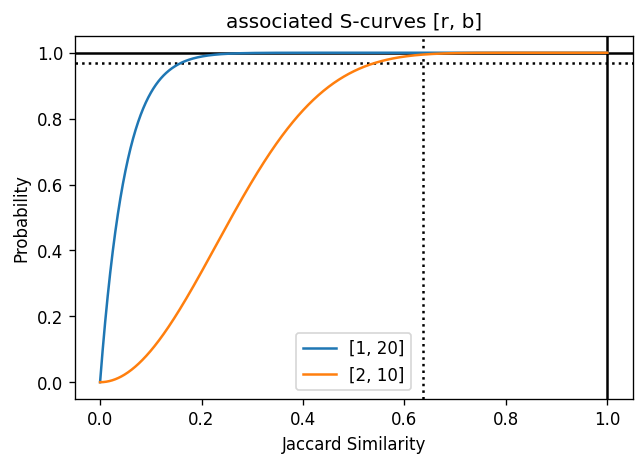

In [17]:
jaccard_threshold = 7/11
n_functions = 20
prob = 0.97

def function(x: float,
             r: int,
             b: int) -> float:
  return 1-(1-x**r)**b

def plot_jaccard(jaccard_threshold: float,
                 prob: float,
                 n_functions: int) -> Tuple[int, int]:
  """A function that plots all the curves generated by all the couples of (r, b)
  which respect the constraints on prob and javvard_threshold.

  Args:
    - jaccard_threshold (float): The threshold on the jaccard similarity between documents in each bin.
    - prob (float): The probabilty of having in each bin documents which are have a jaccard similarity score above the jaccard_threshold.
    - n_functions (int): The number of hash functions to deal with.

  Returns:
    - couple (Tuple[int, int]): The couple of (r, b) that minimize the number of false negatives.
  """
  couples = []

  for i in range(1, int(math.sqrt(n_functions) + 1)):
    if n_functions % i == 0:
      if function(jaccard_threshold, i, n_functions/i) > prob: couples.append((i, int(n_functions/i)))
      if function(jaccard_threshold, n_functions/i, i) > prob and i*i != n_functions: couples.append((int(n_functions/i), i))

  assert len(couples)!=0, "It seems that couples list is empty."

  x = np.linspace(0, 1, num = 1000)

  plt.figure(dpi = 120)
  plt.title("associated S-curves [r, b]")
  plt.xlabel("Jaccard Similarity")
  plt.ylabel("Probability")
  plt.axvline(x = jaccard_threshold, color = 'k', linestyle = ':')
  plt.axhline(y = prob, color = 'k', linestyle = ':')
  plt.axvline(x = 1, color = 'k')
  plt.axhline(y = 1, color = 'k')

  max = 0
  couple = None

  for r, b in couples:
    y = function(x, r, b) 
    plt.plot(x, y, label = f"[{r}, {b}]")

    area = integrate.quad(function, 0, 1, args=(r,b))[0]
    if max < area:
      max = area
      couple = (r, b)

  plt.legend();

  return couple

r, b = plot_jaccard(jaccard_threshold, prob, n_functions)

We define the `LSH()` class which will handle all the functions that we need for Locality Sensitive Hashing.

In [18]:
class LSH():
  """A class to handle the Locality Sensitive Hashing section.

  Args:
    - b (int): The number of bands.

  Attributes:
    - bands (List[Dict[str, List[str]]]): A list of bands, a bands is a Dict which has
                                          as keys...
  """

  def __init__(self,
               b: int):
    
    self.bands = []
    self.b = b
    for _ in range(b):
      self.bands.append({})
    
  def __make_subvects(self,
                      sketch: List[str]) -> np.array:
    """A function to divide a vector in b subvector of r dimension.

    Args:
      - sketch (List[str]): A sketck.

    Returns:
      - np.array : The stack of subvectors.
    """
    n = len(sketch)
    assert n % self.b == 0
    r = int(n / self.b)

    subvecs = []
    for i in range(0, n, r):
      subvecs.append(sketch[i:i+r])
    return np.stack(subvecs)

  def add_sketch(self,
                 sketch: List[str],
                 customer_id: int) -> None:
    """A functions that adds a document (the customer id) to the corresponding bins.

    Args:
      - sketch (List[str]): The MinWiseHashing sketch of the customer id.
      - customer_id (int): The customer id.

    Returns:
      - None
    """
    subvecs = self.__make_subvects(sketch).astype(str)
    for i, subvec in enumerate(subvecs):
      subvec = ",".join(subvec)
      if subvec not in self.bands[i].keys():
        self.bands[i][subvec] = SortedSet()
      self.bands[i][subvec].add(customer_id)

  def add_sketches(self,
                   sketches: Dict[int, List[str]]) -> None:
    """A functions that calls 'add_sketch()' for each sketch in sketches.

    Args:
      - sketches (Dict[int, List[str]]): A dictionary which has as keys the customers id and as values their corresponding sketch.
    
    Returns:
      - None
    """
    for sketch in tqdm(sketches):
      self.add_sketch(sketches[sketch], sketch)

  def single_query(self,
                   sketch: List[str],
                   customer_shingles: SortedSet,
                   shingles: Shingles,
                   t: float) -> SortedSet:
    """A fucntion to query the bins in search of similar customers of our query customer.

    Args:
      - sketch (List[str]): The sketch of our customer.
      - customer_shingles (SortedSet): The shingles of our customer.
      - shingles (Shingles): The Shingles object containing the index of all the shingles.
      - t (float): The jaccard similarity threshold. It can take values between 0 and 1.
    
    Returns:
      - similar (SortedSet): A SortedSet containing all the similar customers of our query customer.
    """
    assert t <= 1 and t >=0, f"Error: t is supposed to be between 0 and 1, instead t equals to {t}."

    similar = SortedSet()

    subvecs = self.__make_subvects(sketch).astype(str)
    for i, subvec in enumerate(subvecs):
      subvec = ",".join(subvec)
      if subvec in self.bands[i].keys():
        for costumer_id in self.bands[i][subvec]:
          if jaccard_similarity(customer_shingles, shingles.get__customer_shingles(costumer_id)) >= t:
            similar.add(costumer_id)

    return similar

  def multiple_query(self,
                     customers_id: List[int],
                     sketches: Dict[int, List[str]],
                     shingles: Shingles,
                     t: float) -> Dict[int, SortedSet]:
    """A functions that calls 'single_query()' for each customer in customers_id.

    Args:
      - customers_id (List[int]): A list of customers id.
      - sketches (Dict[int, List[str]]): The sketches dictionary of those customers id.
      - shingles (Shingles): The Shingles object containing all the shingles.
      - t (float): The jaccard similarity threshold. It can take values between 0 and 1.

    Returns:
      - result (Dict[int, SortedSet]): The dictionary that has as keys the customers id and as values their similar customers.
    """
    assert t <= 1 and t >=0, f"Error: t is supposed to be between 0 and 1, instead t equals to {t}."

    result = {}

    for customer_id in tqdm(customers_id):
      result[customer_id] = self.single_query(sketches[customer_id], shingles.get__query_customer__shingles(shingles.get__customer(customer_id), id=False), shingles, t)

    return result

### From shingles to buckets

We perform the pipeline from the shingles to the lsh.

In [19]:
print("Loading the Shingles object", end="")
shingles = Shingles.loader("shingles.pkl")
print(", done")

print()
print("Some info about the Shingles Object:")
print(shingles)

print()
print(f"Creating all the MinWiseHashing sketches using {n_functions}")
sketches = create__min_wise_hashing__sketches(shingles, n_functions)

lsh = LSH(b)

print()
print("Performing Locality Sensitive Hashing...")
lsh.add_sketches(sketches)

Loading the Shingles object, done

Some info about the Shingles Object:
Number of shingles: 5730.
Number of customers: 882600.

Creating all the MinWiseHashing sketches using 20


  0%|          | 0/882600 [00:00<?, ?it/s]


Performing Locality Sensitive Hashing...


  0%|          | 0/882600 [00:00<?, ?it/s]

## Query time

### Taking the query file:

We download the query file:

In [20]:
query_users_file = gdown.download(url='https://drive.google.com/uc?id=1ob7l9vuujfy8cSNWlpt1shcHWXeLHxPs', quiet=True)

We read the file as a `pd.DataFrame`:

In [21]:
query_users_df = pd.read_csv(query_users_file)

We set the index name to `CustomerID`:

In [22]:
query_users_df.index.name = "CustomerID"

We take a look to the head of the file:

In [23]:
display(query_users_df.head())

CustomerDOB CustGender CustLocation  CustAccountBalance  \
CustomerID                                                           
0              27/7/78          M        DELHI            94695.61   
1              6/11/92          M    PANCHKULA             7584.09   
2              14/8/91          M        PATNA             7180.60   
3               3/1/87          M      CHENNAI            56847.75   
4               4/1/95          M      GURGAON            84950.13   

           TransactionDate  TransactionTime  TransactionAmount (INR)  
CustomerID                                                            
0                   2/9/16           140310                     65.0  
1                   2/9/16           120214                   6025.0  
2                  10/8/16           221732                    541.5  
3                  29/8/16           144138                   1000.0  
4                  25/9/16           233309                     80.0

### We preprocess the file:

In [24]:
aggregate_query_df = descriptive_dataframe(query_users_df)

Display for the balance insights:


BalanceMean  BalanceVar
CustomerID                         
0              94695.61         0.0
1               7584.09         0.0
2               7180.60         0.0
3              56847.75         0.0
4              84950.13         0.0


Display for the transactions insights:


TransactionsSum  TransactionsMean  TransactionsVar  \
CustomerID                                                       
0                      65.0              65.0              0.0   
1                    6025.0            6025.0              0.0   
2                     541.5             541.5              0.0   
3                    1000.0            1000.0              0.0   
4                      80.0              80.0              0.0   

            NumTransactions  
CustomerID                   
0                         1  
1                         1  
2                         1  
3                         1  
4                         1


The combined dataframe:


BalanceMean  BalanceVar  TransactionsSum  TransactionsMean  \
CustomerID                                                               
0              94695.61         0.0             65.0              65.0   
1               7584.09         0.0           6025.0            6025.0   
2               7180.60         0.0            541.5             541.5   
3              56847.75         0.0           1000.0            1000.0   
4              84950.13         0.0             80.0              80.0   

            TransactionsVar  NumTransactions  
CustomerID                                    
0                       0.0                1  
1                       0.0                1  
2                       0.0                1  
3                       0.0                1  
4                       0.0                1

In [25]:
prep_query_df = preprocess_dataframe(aggregate_query_df, step)

BalanceVar  TransactionsVar  BalanceMean  TransactionsSum  \
CustomerID                                                              
0                    0                0        94500                0   
1                    0                0         7500             6000   
2                    0                0         7000              500   
3                    0                0        57000             1000   
4                    0                0        85000                0   

            TransactionsMean  BalanceMeanMagnitude  TransactionsSumMagnitude  \
CustomerID                                                                     
0                          0                     6                         3   
1                       6000                     5                         5   
2                        500                     5                         4   
3                       1000                     6                         3   
4                          0                     6                         3   

            TransactionsMeanMagnitude  NumTransactions  
CustomerID                                              
0                                   3                1  
1                                   5                1  
2                                   4                1  
3                                   3                1  
4                                   3                1

### We create the shingles:

In [26]:
query_customers_id = shingles.add_query_shingles(prep_query_df)

Populating the Shingle object...


  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
print(shingles)

Number of shingles: 5730.
Number of customers: 882650.


### We compute the MinWiseHashing sketches:

In [28]:
query_sketches = create__min_wise_hashing__sketches(shingles, n_functions, query_customers_id)

  0%|          | 0/50 [00:00<?, ?it/s]

### We find the similar users:


We can call the `lsh.multiple_query()` method to retrieve the similars customers for a given list of customers like so:

```python
similars = lsh.multiple_query(query_customers_id, query_sketches, shingles, 0.90)
```

This will take more than an hour, so we have saved the result in our S3 Bucket.

**Note**: it is possibel to reduce the required time by setting the initial jaccard threshold to something like $0.90$ and then taking the couple $(r, b)$ that minimizes the area under the S-curve; in this way we minimize the number of false positives and so the number of jaccard similarity comparison that we have to do at the end... the trade off in doing so is that we're increasing the number of false negatives...

Normally (if resources allow it) it is better to minimize the false negatives, because while it is always possible to reduce false positives in a second step, reducing false negatives afterwards it's impossible.



In [29]:
download_zip("https://adm-hw4-mep27.s3.amazonaws.com/similars.zip")

File saved in /content/similars.zip
Unzipping similars.zip, done.


In [30]:
similars = load("similars.pkl")

We translate each Shingles customer id in normal customer id:

In [31]:
def to__normal__customer_id(d: Dict[int, SortedSet],
                            shingles: Shingles) -> Dict[int, SortedSet]:
  """Translates Shingles customers id in normal customers id.

  Args:
    - d (Dict[int, SortedSet]): The dictionary having as keys customers id and as values similar customers id.
    - shingles (Shingles): The Shingles object.

  Returns:
    - result (Dict[int, SortedSet]): The translated dictionary.
  """
  result = {}

  for customer_id in d:
    result[shingles.get__customer(customer_id)] = SortedSet(map(shingles.get__customer, d[customer_id]))

  return result

In [32]:
similars = to__normal__customer_id(similars, shingles)

### Visualize the results:

In [33]:
def visualize_results(d: Dict[int, SortedSet],
                      query_df: pd.DataFrame,
                      original_df: pd.DataFrame,
                      seed: int = 42):
  """A simple function to visualize a random result.

  Args:
    - d (Dict[int, SortedSet]): The dictionary which has as keys the customers id and as values their similars customers id.
    - query_df (pd.DataFrame): The dataframe with the query customers.
    - original_df (pd.DataFrame): The original dataset.
    - seed (int): The seed for the random module.

  Returns:
    - None
  """
  random.seed(seed)

  customer = random.choice(list(d.keys()))

  print(f"We visualize the query_customer {customer}:")
  display(pd.DataFrame(query_df.loc[customer]))

  print()
  print("We visualize the results:")
  display(original_df.loc[d[customer]])

  return None

In [34]:
visualize_results(similars, aggregate_query_df, aggregate_df)

We visualize the query_customer 40:


40
BalanceMean       2887.39
BalanceVar           0.00
TransactionsSum     20.00
TransactionsMean    20.00
TransactionsVar      0.00
NumTransactions      1.00


We visualize the results:


BalanceMean  BalanceVar  TransactionsSum  TransactionsMean  \
CustomerID                                                               
C1012586        2884.96         0.0             30.0              30.0   
C1014422        2753.65         0.0             24.0              24.0   
C1016170        3017.51         0.0             20.0              20.0   
C1016242        2786.47         0.0             16.0              16.0   
C1018031        2958.29         0.0             11.0              11.0   
...                 ...         ...              ...               ...   
C9035551        2758.29         0.0             20.0              20.0   
C9035720        2992.20         0.0             20.0              20.0   
C9037732        2798.95         0.0             30.0              30.0   
C9037812        2752.40         0.0             25.0              25.0   
C9040760        3076.29         0.0             20.0              20.0   

            TransactionsVar  NumTransactions  
CustomerID                                    
C1012586                0.0                1  
C1014422                0.0                1  
C1016170                0.0                1  
C1016242                0.0                1  
C1018031                0.0                1  
...                     ...              ...  
C9035551                0.0                1  
C9035720                0.0                1  
C9037732                0.0                1  
C9037812                0.0                1  
C9040760                0.0                1  

[922 rows x 6 columns]

### We can now check the error of our results:

In [35]:
def check_error(d: Dict[int, SortedSet],
                query_df: pd.DataFrame,
                original_df: pd.DataFrame,
                columns: List[str],
                step: int = 500) -> None:
  """A simple routine to check the error of our results.

  Args:
    - d (Dict[int, SortedSet]): The dictionary which has as keys the customers id and as values their similars customers id.
    - query_df (pd.DataFrame): The dataframe with the query customers.
    - original_df (pd.DataFrame): The original dataset.
    - columns (List[str]): The list of columns on which we want to check the error.
    - step (int): The step of discretization used in preprocessing. Default 500.

  Returns:
  - None
  """
  result = pd.DataFrame()

  for customer_id in d:

    partial = {}

    for column in columns:

      value = query_df.loc[customer_id][column]
      partial[column] = math.sqrt(original_df.loc[d[customer_id]][column].apply(lambda x: (x-value)**2).mean())

    result = pd.concat([result, pd.DataFrame(partial, index=[customer_id])])

  total = np.sum([len(d[elem]) > 1 for elem in d])

  print(f"Number of customers of which we're able to find similar customers: {total} / {len(d)}.")
  print()
  print(f"Number of customers of which we didn't find any similar customers: {len(d)-total} / {len(d)}.")

  print()
  print("Mean of the all errors:")
  display(result.mean())

  print()
  print(f"Are all the error covered by the step '{step}'?", end="\t")

  maximum = result.max()

  answer = np.sum([1 if i <= 500 else 0 for i in maximum.values]) == len(maximum)

  print("Yes." if answer == True else "No.")

  print()
  print("Maximum error:")
  display(result.max())

  print()
  print("Minimum error:")
  display(result.min())

  print()
  print("Display all the errors commited:")
  display(result)

  return None

In [36]:
check_error(similars, aggregate_query_df, aggregate_df, ["BalanceMean", "TransactionsSum", "TransactionsMean"], step=step)

Number of customers of which we're able to find similar customers: 44 / 50.

Number of customers of which we didn't find any similar customers: 6 / 50.

Mean of the all errors:


BalanceMean         170.355200
TransactionsSum      80.999521
TransactionsMean     80.999521
dtype: float64


Are all the error covered by the step '500'?	Yes.

Maximum error:


BalanceMean         303.470497
TransactionsSum     285.377013
TransactionsMean    285.377013
dtype: float64


Minimum error:


BalanceMean         0.0
TransactionsSum     0.0
TransactionsMean    0.0
dtype: float64


Display all the errors commited:


BalanceMean  TransactionsSum  TransactionsMean
0    271.643097        14.537308         14.537308
1    177.473440       118.236894        118.236894
2    230.045022        85.147266         85.147266
3    156.699582       131.220673        131.220673
4    175.136851        21.338509         21.338509
5    193.991613        27.672753         27.672753
6    198.883448         8.093122          8.093122
7     62.105052        22.167291         22.167291
8    185.090257        27.462625         27.462625
9      0.000000        40.500000         40.500000
10   140.903677        27.531877         27.531877
11    24.297713       285.377013        285.377013
12   255.778556       131.605654        131.605654
13   283.368731        91.849984         91.849984
14   255.921112        21.334675         21.334675
15   226.470325       107.043693        107.043693
16   143.278043        52.614232         52.614232
17   303.470497       169.494354        169.494354
18   150.080113        18.055546         18.055546
19   166.449617        51.680819         51.680819
20     0.000000         0.000000          0.000000
21   146.366237       204.958262        204.958262
22   153.871713        53.352647         53.352647
23   151.817192       123.912221        123.912221
24   209.261332        56.187478         56.187478
25    91.745802        73.569395         73.569395
26   153.325229       142.108641        142.108641
27   193.836407        80.174482         80.174482
28   246.926889        82.608242         82.608242
29   109.114754       135.909663        135.909663
30   113.098571        91.175655         91.175655
31     0.000000        69.542793         69.542793
32   275.560686        21.170122         21.170122
33   215.283356       271.024868        271.024868
34     0.000000         0.000000          0.000000
35   258.278387        87.030894         87.030894
36          NaN              NaN               NaN
37   216.374379        75.651087         75.651087
38   221.204473       147.404608        147.404608
39   138.453594        16.584561         16.584561
40   134.355407         7.588078          7.588078
41   145.712473        76.994654         76.994654
42   184.559677       141.808336        141.808336
43   231.025595        82.210498         82.210498
44   277.880817        78.200838         78.200838
45          NaN              NaN               NaN
46   228.110268        17.522410         17.522410
47          NaN              NaN               NaN
48   168.581326       109.209349        109.209349
49   140.863076       108.113436        108.113436

### We save the dictionary in a tsv file:

In [37]:
def save__dictionary__to__csv(d: Dict[int, SortedSet],
                              path: str,
                              delimiter: str = ",") -> None:
  """A function to save the dictionary of similar customers in a csv file, similars customers are grouped in lists.

  Args:
    - d (Dict[int, SortedSet]): The dictionary with similars customers.
    - path (str): The path where to save the csv file.
    - delimiter (str): The delimiter to use for the csv file. Default \t.

  Returns:
    - None
  """
  with open(path, 'w', encoding="utf-8") as result:

    csv_writer = csv.writer(result, delimiter=delimiter, quotechar='"', quoting=csv.QUOTE_NONE)
    csv_writer.writerow(["CustomerID", "SimilarCustomers"])

    for customer in d:
      csv_writer.writerow([customer, list(d[customer])])

  return None

In [38]:
save__dictionary__to__csv(similars, "results.tsv", delimiter="\t")

It is possible to download the `result.tsv` as a zip file from [here](https://adm-hw4-mep27.s3.amazonaws.com/results.zip).

# Q2. **Grouping Customers Together**

In [ ]:
import pandas as pd 
import numpy as np
import datetime as dt
from datetime import datetime
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import warnings

In [ ]:
warnings.filterwarnings(action='ignore')

## 2.1.- Getting your data + feature engineering

First we read the dataset from the `csv` file to start working with it.

In [2]:
data=pd.read_csv('bank_transactions.csv')

20 own features:

- Max of transaction 
- Min of transaction 
- Most frequent time of day 
- Age of Costumer from the transaction
- Day of the Week of most Trasactions
- Month of most Trasactions 
- Month when they had more money 
- Num of transactions per month 
- Location where more money is sent from
- Season of most transactions 
- Does the customer change its sex? (1-YES | 0-NO) 
- Period of the day when most transactions are done 
- Section of the population: {Students, Adults, Retired} when last transaction
- Rich or not overall
- If the person's balance is very volatile or not. (1-YES | 0-NO) 
- Log(Account Balance) on average || If Account==0 -> log()=-1
- Increment CustAccountBalance in the year  
- Total amount spent on transactions 
- How many cities have been visitied by that person 
- How many transactions are done at night.


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.TransactionDate=pd.to_datetime(data.TransactionDate)

In [ ]:
data.CustomerDOB=pd.to_datetime(data.CustomerDOB)

In [ ]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

<AxesSubplot:>

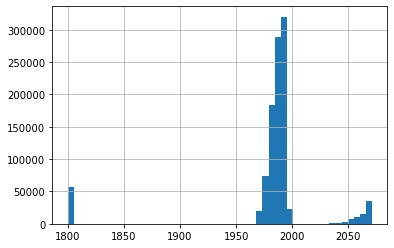

In [7]:
data.CustomerDOB.dt.year.hist(bins=50)

In [8]:
data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB']=data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB']-pd.DateOffset(years=100)

We can just drop the data from the people born in 1800s, or consider there is a mistake with the rounding and they are born in 2000, we would rather do that than drop data.

In [9]:
data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']=data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']+pd.DateOffset(years=200)

<AxesSubplot:>

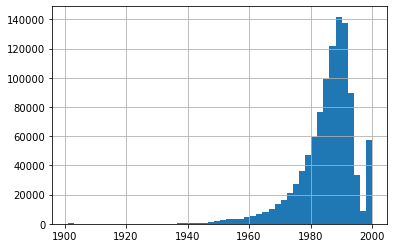

In [10]:
data.CustomerDOB.dt.year.hist(bins=50)

In [11]:
data.CustomerDOB[data.CustomerDOB.dt.year==2000].count()

56561

In [12]:
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].astype(int)

Let's try to sort out the locations:

Make a list of the cities with length 1 and then, for the ones that have larger length, looks which one matches and then put it. If non matches, oh well :( . 

Here we create a list with all the locations formed of 1 word, which we are going to consider to be the actual citie names.

In [15]:
cities=[]

for i in data.CustLocation:
    if len(i.split())==1 and bool(re.match('[A-Z]',i)):
        cities.append(i)
cities=np.unique(cities)

Now, for all the `CustLocations` that have length greater than $1$, we will see which of the existing do they match and substitute it to be able to work with the data. If there is no match, we assign a `-`.

In [127]:
locations=[]
for i in tqdm(range(len(data))):
    if len((data.CustLocation.iloc[i]).split())>1:
        k,j=0,0
        while(k==0):
            if j==len(cities)-1:
                k=1
                locations.append('-')
                pass
            if cities[j] in data.CustLocation.iloc[i]:
                locations.append(cities[j])
                k+=1
            j+=1
    else:
        locations.append(data.CustLocation.iloc[i])

100%|████████████████████████████████| 1041614/1041614 [26:43<00:00, 649.75it/s]


In [151]:
locations=locations[0:len(locations)-2]

In [152]:
data['Location']=locations

In [153]:
data.Locations[data.Locations=='-'].count()

6036

## Let's make the new features for the DataSet

In [6]:
costumers=data['CustomerID']

In [7]:
costumers=np.unique(costumers)

Now that we have a string with all the costumers, we will search for all the extra features that we have decided to put into the dataset, we will build a new one with the previous and the new features where we also replace the old `CustLocation` by what we have previously named as `Location.` 

In [60]:
def get_features(id):
    
    features={}
    
    t=data[data['CustomerID']==id]
    
    features['CustomerID']=id
    
    #Number of Transactions
    features['N_Transactions']=len(t)
    
    #Number of transaction with balance bigger than 100
    features['N_Transaction_100']=len(t[t.CustAccountBalance>100])
    
    #Average amount of the transactions
    features['AverageAmount']=(t['TransactionAmount (INR)'].sum())/len(t)
    
    #Average Balance
    features['Average Balance']=((t.CustAccountBalance.sum())/len(t)).round(4)
    
    #Average Utilisation
    features['Utilisation']=((t.CustAccountBalance-t['TransactionAmount (INR)']).sum()/len(t)).round(4)
    
    #Most Common Gender (if they are equal, we'll asigne the first one)
    f=t['CustGender'][t['CustGender']=='F'].count()
    m=t['CustGender'][t['CustGender']=='M'].count()
    if m>f:
        features['MostCommonGender']='M'
    elif f>m:
        features['MostCommonGender']='F'
    else:
        features['MostCommonGender']=t.iloc[0]['CustGender']
    
    #Most Frequent Location
    features['MostFreqLocation']=Counter(t['Location']).most_common(1)[0][0]
    
    #Now we proceed with the 20 one selected by us
    
    #Max of Transactions
    features['MaxTransaction']=max(t['TransactionAmount (INR)'])
    
    #Min of Transactions
    features['MinTransaction']=min(t['TransactionAmount (INR)'])
    
    #Most frequent time of Transaction (hour)
    features['MostFreqTime']=Counter(t.TransactionTime.dt.hour).most_common(1)[0][0]
    
    #Age of Customer in first transaction
    features['AverageAge']=((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y')).iloc[len(t)-1].round()
    
    #Day of the Week with most transactions
    days_week={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    aux=Counter(t.TransactionDate.dt.day_of_week).most_common(1)[0][0]
    features['Day_of_Week']=days_week[aux]
    
    #Month with most transactions
    months={1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
    aux=Counter(t.TransactionDate.dt.month).most_common(1)[0][0]
    features['Month']=months[aux]
    
    #Month with higher Balance
    features['Month_Higher_Balance']=t[t['CustAccountBalance']==max(t['CustAccountBalance'])]['TransactionDate'].dt.month.apply(lambda x:months[x]).iloc[0]

    #Location where more money is sent from
    features['MoreMoneyLoc']=t[t['TransactionAmount (INR)']==max(t['TransactionAmount (INR)'])].Location.iloc[0]
    
    #Season of First Transaction
    season={1:'W',2:'W',3:'Sp',4:'Sp',5:'Sp',6:'Su',7:'Su',8:'Su',9:'Au',10:'Au',11:'Au',12:'W'}
    features['Season']=season[t['TransactionDate'].dt.month.iloc[0]]
    
    #Does the Customer Change Sex along transactions?
    if m!=0 and f!=0:
        features['SexChange']=1
    else:
        features['SexChange']=0
    
    #Period of the Day of more transactions
    def period(time):
        if time in [21,22,23,24,0,1,2,3,4,5]:
            return 'Night'
        elif time in [6,7,8,9,10,11,12]:
            return 'Morning'
        elif time in [13,14,15,16]:
            return 'Afternoon'
        elif time in [17,18,19,20]:
            return 'Evening'
        
    aux=Counter(t.TransactionDate.dt.hour).most_common(1)[0][0]
    features['Period']=period(aux)
    
    # Section of Population
    def section(age):
        if age<=25:
            return 'Student'
        elif 25<age and age<65:
            return 'Adult'
        elif age>=65:
            return 'Retired'
        
    features['Section']=section(((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y')).iloc[len(t)-1])
    
    # Rich or Poor in the moment of transaction (we will consider rich if in the moment has a balance over 100.000)
    def richpoor(x):
        if x<100000:
            return 'Poor'
        else:
            return 'Rich'
    features['RichPoor']=richpoor(t.CustAccountBalance.sum()/len(t))
    
    #Is the Balance Volatile or Variable? If the standard deviation is higher than then average, we'll say it is(1)
    features['Volatile_Balance']=int(t.CustAccountBalance.std()>t.CustAccountBalance.mean())
    
    #Log Account Balance:
    aux=np.log10(t.CustAccountBalance.sum()).round(4)
    if aux==-np.inf:
        aux=-1
    features['LogCustAccountBalance']=aux
    
    #Increment CustAccountBalance in the year: final -initial
    features['Increment']=(t['CustAccountBalance'].iloc[len(t)-1]-t['CustAccountBalance'].iloc[0]).round(4)
    
    #Total Amount Spent on Transactions
    features['TotalTransactions']=t['TransactionAmount (INR)'].sum()
    
    #Cities Visited
    features['Num_Cities']=len(np.unique(t['Location']))
    
    #Transactions Done at Night
    night=t['TransactionTime'].dt.hour.apply(period)
    features['NightTransactions']=len(night[night=='Night'])
    
    return features

In [154]:
#We put the first `CustomerID` and we proceed with the rest of the features
info=get_features(costumers[0])
new_data=pd.DataFrame(info,index=[0])

for i in tqdm(range(len(costumers[1:]))):
    info=get_features(costumers[i])
    aux=pd.DataFrame(info,index=[i+1])
    new_data=new_data.append(aux)

In [74]:
data=new_data[['CustomerID','N_Transactions','N_Transaction_100','AverageAmount','Average Balance','Utilisation','MostCommonGender','MostFreqLocation','MaxTransaction','MinTransaction','MostFreqTime','AverageAge','Day_of_Week','Month','Month_Higher_Balance','MoreMoneyLoc','Season','SexChange','Period','Section','RichPoor','Volatile_Balance','LogCustAccountBalance','Increment','TotalTransactions','Num_Cities','NightTransactions']]

In [75]:
data.drop_duplicates(inplace=True)

In [79]:
data.set_index('CustomerID',inplace=True)

In [81]:
data.to_csv('Bank_Features.csv',sep='\t')
data.to_pickle('NewData.pkl')

## 2.2.- Choose your features!

In [1]:
import pandas as pd 
import sklearn.preprocessing
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import Counter

In [2]:
data=pd.read_pickle('NewData.pkl')

We put the gender information as a boolean feature where it is $0$ if the `MostCommonGender` is a male, and $1$ if it is a female. 

We set back the indexes of the dataframes to numerical values in order to be able to work properly with the data.

In [3]:
data.reset_index(inplace=True)
data=data[['N_Transactions','N_Transaction_100','AverageAmount','Average Balance','Utilisation','MostCommonGender','MostFreqLocation','MaxTransaction','MinTransaction','MostFreqTime','AverageAge','Day_of_Week','Month','Month_Higher_Balance','MoreMoneyLoc','Season','SexChange','Period','Section','RichPoor','Volatile_Balance','LogCustAccountBalance','Increment','TotalTransactions','Num_Cities','NightTransactions']]

From now on, we will consider that the row $i$ refers to the data of the customerID in the $i-th$ position in the previous indexes.

In [4]:
data

N_Transactions  N_Transaction_100  AverageAmount  Average Balance  \
0                    2                  2         2553.0        76340.635   
1                    1                  1         1499.0        24204.490   
2                    2                  2          727.5       100112.950   
3                    1                  1           30.0          496.180   
4                    1                  1         5000.0        87058.650   
...                ...                ...            ...              ...   
879352               1                  1          590.0         8752.390   
879353               1                  1          691.0       133067.230   
879354               1                  1          222.0        96063.460   
879355               1                  1          126.0         5559.750   
879356               1                  1           50.0        35295.920   

        Utilisation MostCommonGender MostFreqLocation  MaxTransaction  \
0         73787.635                F          CHENNAI            4750   
1         22705.490                M           MOHALI            1499   
2         99385.450                F            DELHI            1205   
3           466.180                F          GURGAON              30   
4         82058.650                M            DELHI            5000   
...             ...              ...              ...             ...   
879352     8162.390                M        BANGALORE             590   
879353   132376.230                M            HAORA             691   
879354    95841.460                M             PUNE             222   
879355     5433.750                M        BANGALORE             126   
879356    35245.920                M          GURGAON              50   

        MinTransaction  MostFreqTime  ...  SexChange Period  Section RichPoor  \
0                  356            12  ...          1  Night  Retired     Poor   
1                 1499            20  ...          0  Night    Adult     Poor   
2                  250            15  ...          1  Night  Retired     Rich   
3                   30            17  ...          0  Night    Adult     Poor   
4                 5000            14  ...          0  Night    Adult     Poor   
...                ...           ...  ...        ...    ...      ...      ...   
879352             590            13  ...          0  Night    Adult     Poor   
879353             691             0  ...          0  Night    Adult     Rich   
879354             222            12  ...          0  Night    Adult     Poor   
879355             126            12  ...          0  Night    Adult     Poor   
879356              50            21  ...          0  Night    Adult     Poor   

       Volatile_Balance LogCustAccountBalance  Increment TotalTransactions  \
0                     0                5.1838   87679.81              5106   
1                     0                4.3839       0.00              1499   
2                     0                5.3015  123471.62              1455   
3                     0                2.6956       0.00                30   
4                     0                4.9398       0.00              5000   
...                 ...                   ...        ...               ...   
879352                0                3.9421       0.00               590   
879353                0                5.1241       0.00               691   
879354                0                4.9826       0.00               222   
879355                0                3.7451       0.00               126   
879356                0                4.5477       0.00                50   

       Num_Cities NightTransactions  
0               2                 1  
1               1                 0  
2               2                 1  
3               1                 0  
4               1                 0  
...           ...               ...  
879352          1             

We define a function to select the features that are numerical:

In [5]:
def no_categorical(df):
    no_object_df = df.select_dtypes(exclude = 'object') 
    return no_object_df

In [6]:
numdata=no_categorical(data)

In [7]:
numdata

N_Transactions  N_Transaction_100  AverageAmount  Average Balance  \
0                    2                  2         2553.0        76340.635   
1                    1                  1         1499.0        24204.490   
2                    2                  2          727.5       100112.950   
3                    1                  1           30.0          496.180   
4                    1                  1         5000.0        87058.650   
...                ...                ...            ...              ...   
879352               1                  1          590.0         8752.390   
879353               1                  1          691.0       133067.230   
879354               1                  1          222.0        96063.460   
879355               1                  1          126.0         5559.750   
879356               1                  1           50.0        35295.920   

        Utilisation  MaxTransaction  MinTransaction  MostFreqTime  AverageAge  \
0         73787.635            4750             356            12        66.0   
1         22705.490            1499            1499            20        28.0   
2         99385.450            1205             250            15        66.0   
3           466.180              30              30            17        28.0   
4         82058.650            5000            5000            14        28.0   
...             ...             ...             ...           ...         ...   
879352     8162.390             590             590            13        28.0   
879353   132376.230             691             691             0        28.0   
879354    95841.460             222             222            12        28.0   
879355     5433.750             126             126            12        28.0   
879356    35245.920              50              50            21        28.0   

        SexChange  Volatile_Balance  LogCustAccountBalance  Increment  \
0               1                 0                 5.1838   87679.81   
1               0                 0                 4.3839       0.00   
2               1                 0                 5.3015  123471.62   
3               0                 0                 2.6956       0.00   
4               0                 0                 4.9398       0.00   
...           ...               ...                    ...        ...   
879352          0                 0                 3.9421       0.00   
879353          0                 0                 5.1241       0.00   
879354          0                 0                 4.9826       0.00   
879355          0                 0                 3.7451       0.00   
879356          0                 0                 4.5477       0.00   

        TotalTransactions  Num_Cities  NightTransactions  
0                    5106           2                  1  
1                    1499           1                  0  
2                    1455           2                  1  
3                      30           1                  0  
4                    5000           1                  0  
...                   ...         ...                ...  
879352                590           1                  0  
879353                691           1                  1  
879354                222           1                  0  
879355                126           1                  0  
879356                 50           1                  1  

[879357 rows x 16 columns]

In [8]:
numdata.describe()

N_Transactions  N_Transaction_100  AverageAmount  Average Balance  \
count   879357.000000       879357.00000   8.793570e+05     8.793570e+05   
mean         1.184517            1.11345   1.566734e+03     1.147151e+05   
std          0.448954            0.49441   6.433249e+03     8.010842e+05   
min          1.000000            0.00000   0.000000e+00     0.000000e+00   
25%          1.000000            1.00000   1.905000e+02     5.591270e+03   
50%          1.000000            1.00000   5.000000e+02     1.866578e+04   
75%          1.000000            1.00000   1.241000e+03     6.154197e+04   
max          6.000000            6.00000   1.560034e+06     1.150355e+08   

        Utilisation  MaxTransaction  MinTransaction   MostFreqTime  \
count  8.793570e+05    8.793570e+05    8.793570e+05  879357.000000   
mean   1.131484e+05    1.777717e+03    1.374435e+03      15.418461   
std    8.007328e+05    7.107526e+03    6.243189e+03       5.125049   
min   -1.517546e+06    0.000000e+00    0.000000e+00       0.000000   
25%    4.753320e+03    2.000000e+02    1.300000e+02      12.000000   
50%    1.754926e+04    5.000000e+02    3.750000e+02      16.000000   
75%    5.981068e+04    1.408000e+03    1.000000e+03      20.000000   
max    1.150339e+08    1.560034e+06    1.560034e+06      23.000000   

          AverageAge      SexChange  Volatile_Balance  LogCustAccountBalance  \
count  879357.000000  879357.000000     879357.000000          879357.000000   
mean       33.347005       0.067482          0.089283               4.208273   
std        13.243177       0.250855          0.285153               1.088013   
min        26.000000       0.000000          0.000000              -2.000000   
25%        28.000000       0.000000          0.000000               3.778200   
50%        28.000000       0.000000          0.000000               4.326700   
75%        28.000000       0.000000          0.000000               4.867400   
max        66.000000       1.000000          1.000000               8.216100   

          Increment  TotalTransactions     Num_Cities  NightTransactions  
count  8.793570e+05       8.793570e+05  879357.000000      879357.000000  
mean   6.133945e+02       1.854996e+03       1.173211           0.240144  
std    5.002734e+05       7.188314e+03       0.431113           0.447040  
min   -8.224243e+07       0.000000e+00       1.000000           0.000000  
25%    0.000000e+00       2.000000e+02       1.000000           0.000000  
50%    0.000000e+00       5.330000e+02       1.000000           0.000000  
75%    0.000000e+00       1.500000e+03       1.000000           0.000000  
max    1.150344e+08       1.560034e+06       6.000000           4.000000

In [9]:
norm_data=pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(numdata))

In [10]:
norm_data

0         1         2         3         4         5         6   \
0       1.816407  1.793148  0.153308 -0.047903 -0.049156  0.418188 -0.163127   
1      -0.410992 -0.229465 -0.010529 -0.112985 -0.112950 -0.039214  0.019952   
2       1.816407  1.793148 -0.130453 -0.018228 -0.017188 -0.080579 -0.180106   
3      -0.410992 -0.229465 -0.238874 -0.142581 -0.140724 -0.245897 -0.215344   
4      -0.410992 -0.229465  0.533676 -0.034524 -0.038827  0.453362  0.580724   
...          ...       ...       ...       ...       ...       ...       ...   
879352 -0.410992 -0.229465 -0.151826 -0.132274 -0.131113 -0.167107 -0.125647   
879353 -0.410992 -0.229465 -0.136126  0.022909  0.024013 -0.152897 -0.109469   
879354 -0.410992 -0.229465 -0.209029 -0.023283 -0.021614 -0.218883 -0.184591   
879355 -0.410992 -0.229465 -0.223951 -0.136260 -0.134520 -0.232390 -0.199968   
879356 -0.410992 -0.229465 -0.235765 -0.099140 -0.097289 -0.243083 -0.212141   

              7         8         9         10        11        12        13  \
0      -0.667011  2.465648  3.717352 -0.313108  0.896613  0.174038  0.452263   
1       0.893951 -0.403756 -0.269009 -0.313108  0.161420 -0.001226 -0.049524   
2      -0.081650  2.465648  3.717352 -0.313108  1.004792  0.245582 -0.055645   
3       0.308590 -0.403756 -0.269009 -0.313108 -1.390308 -0.001226 -0.253884   
4      -0.276770 -0.403756 -0.269009 -0.313108  0.672351 -0.001226  0.437517   
...          ...       ...       ...       ...       ...       ...       ...   
879352 -0.471891 -0.403756 -0.269009 -0.313108 -0.244642 -0.001226 -0.175980   
879353 -3.008453 -0.403756 -0.269009 -0.313108  0.841743 -0.001226 -0.161929   
879354 -0.667011 -0.403756 -0.269009 -0.313108  0.711689 -0.001226 -0.227174   
879355 -0.667011 -0.403756 -0.269009 -0.313108 -0.425706 -0.001226 -0.240529   
879356  1.089071 -0.403756 -0.269009 -0.313108  0.311970 -0.001226 -0.251102   

              14        15  
0       1.917804  1.699753  
1      -0.401776 -0.537187  
2       1.917804  1.699753  
3      -0.401776 -0.537187  
4      -0.401776 -0.537187  
...          ...       ...  
879352 -0.401776 -0.537187  
879353 -0.401776  1.699753  
879354 -0.401776 -0.537187  
879355 -0.401776 -0.537187  
879356 -0.401776  1.699753  

[879357 rows x 16 columns]

### 2.2.2.- PCA method and 2.2.3.- Its application to our data

# Dimensionality Reduction Techniques:

## - Principal component analysis (PCA)

PCA aims to reduce complex information and provide a simplified structure hidden underneath the higher dimensionality. It is used when all the dimensions are numerical (all numerical features). 

## - Multiple correspondence analysis (MCA)

MCA is a Dimensionality Reduction technique that is traditionally applied to contingency tables. It means that it is more appropriate to apply MCA to categorical features (for more than two categorical features). 

## - Factor Analysis of Mixed Data (FAMD)

FAMD is a technique dedicated to the Dimensionality Reduction of data set containing both quantitative and qualitative features. It means that FAMD is applied to data with both categorical and numerical features. Roughly speaking, the FAMD algorithm can be seen as a mix between PCA and MCA.



So among these technics we have decided to `remove some features` which are `categorical` and use **PCA** for our features that are numerical, since they respresent the majority.

In [11]:
pca=PCA(n_components=16)
dataPCA=pca.fit_transform(norm_data)
variances=(pca.explained_variance_ratio_)
print(variances)
print(np.sum(pca.explained_variance_ratio_))

[2.86010139e-01 2.38210891e-01 1.29666043e-01 7.13690077e-02
 6.23054744e-02 5.68617446e-02 5.02855905e-02 3.65587700e-02
 2.89918558e-02 2.03961910e-02 1.02851063e-02 7.22157764e-03
 1.64779141e-03 1.31437320e-04 5.83804760e-05 1.35883170e-24]
0.9999999999999999


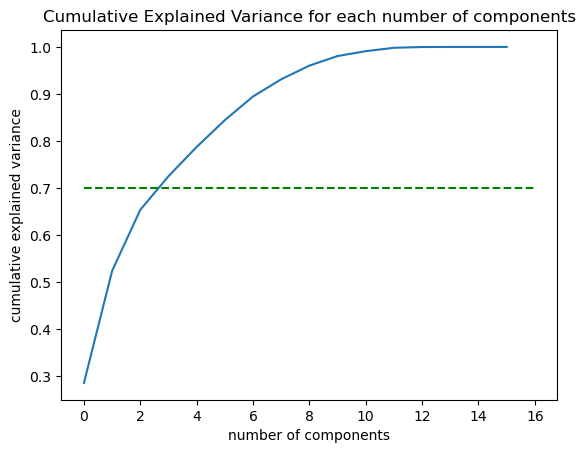

In [16]:
plt.plot(np.cumsum(variances))
plt.hlines(0.7,xmin=0,xmax=16,colors='green',linestyles='--')
plt.ticklabel_format(axis="y", style="plain")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for each number of components')
plt.show()

Hence, we observe that by selecting only the 5 features with more variance, we obtain a fraction of our dataset that retains more than the $70\%$ of the variance. In fact,

In [11]:
pca=PCA(n_components=5)
dataPCA=pca.fit_transform(norm_data)
variances=(pca.explained_variance_ratio_)
print(variances)
print(np.sum(pca.explained_variance_ratio_))

[0.28601014 0.23821089 0.12966604 0.07136901 0.06230547]
0.7875615549750624


Observe that we only we obtain the $78.76\%$ of the total variance. And the data obtained is:

In [12]:
pca_data=pd.DataFrame(dataPCA)
pca_data.head()

0         1         2         3         4
0  4.817054 -0.586794 -0.277843  0.201062  0.247229
1 -0.832107  0.150922 -0.039666  0.378790 -0.134573
2  4.690688 -1.213728 -0.135045  0.637628  0.254586
3 -1.212687 -0.327942 -0.404314 -0.029126  0.239815
4 -0.540078  1.187824  0.083150 -0.502009 -0.181859

Now we match the inital data that we had with the one we have obtained from PCA to see which feature are we selecting as the ones mantaining the most variance among them all.

In [13]:
final_data = data.join(pca_data) 
final_data

N_Transactions  N_Transaction_100  AverageAmount  Average Balance  \
0                    2                  2         2553.0        76340.635   
1                    1                  1         1499.0        24204.490   
2                    2                  2          727.5       100112.950   
3                    1                  1           30.0          496.180   
4                    1                  1         5000.0        87058.650   
...                ...                ...            ...              ...   
879352               1                  1          590.0         8752.390   
879353               1                  1          691.0       133067.230   
879354               1                  1          222.0        96063.460   
879355               1                  1          126.0         5559.750   
879356               1                  1           50.0        35295.920   

        Utilisation MostCommonGender MostFreqLocation  MaxTransaction  \
0         73787.635                F          CHENNAI            4750   
1         22705.490                M           MOHALI            1499   
2         99385.450                F            DELHI            1205   
3           466.180                F          GURGAON              30   
4         82058.650                M            DELHI            5000   
...             ...              ...              ...             ...   
879352     8162.390                M        BANGALORE             590   
879353   132376.230                M            HAORA             691   
879354    95841.460                M             PUNE             222   
879355     5433.750                M        BANGALORE             126   
879356    35245.920                M          GURGAON              50   

        MinTransaction  MostFreqTime  ...  LogCustAccountBalance  Increment  \
0                  356            12  ...                 5.1838   87679.81   
1                 1499            20  ...                 4.3839       0.00   
2                  250            15  ...                 5.3015  123471.62   
3                   30            17  ...                 2.6956       0.00   
4                 5000            14  ...                 4.9398       0.00   
...                ...           ...  ...                    ...        ...   
879352             590            13  ...                 3.9421       0.00   
879353             691             0  ...                 5.1241       0.00   
879354             222            12  ...                 4.9826       0.00   
879355             126            12  ...                 3.7451       0.00   
879356              50            21  ...                 4.5477       0.00   

       TotalTransactions Num_Cities NightTransactions         0         1  \
0                   5106          2                 1  4.817054 -0.586794   
1                   1499          1                 0 -0.832107  0.150922   
2                   1455          2                 1  4.690688 -1.213728   
3                     30          1                 0 -1.212687 -0.327942   
4                   5000          1                 0 -0.540078  1.187824   
...                  ...        ...               ...       ...       ...   
879352               590          1                 0 -0.972510 -0.130858   
879353               691          1                 1 -0.537152 -0.146333   
879354               222          1                 0 -0.810131 -0.195286   
879355               126          1                 0 -1.034822 -0.271912   
879356                50          1                 1 -0.646926 -0.352818   

               2         3         4  
0      -0.277843  0.201062  0.247229  
1      -0.039666  0.378790 -0.134573  
2      -0.135045  0.637628  0.254586  
3      -0.404314 -0.029126  0.239815  
4       0.083150 -0.502009 -0.181859  
...          ...       ...       ...  
879352 -0.127072 -0.640622  0.009153  
879353  0.301511 -1.

In [272]:
final_data.to_csv('PCA_Data.csv',sep='\t')
final_data.to_pickle('PCA_Data.pkl')


In [135]:
pca_data.to_csv('PCA.csv')

## 2.3.- Clustering

Now we will give our own implementation of **K-Means** using MapReduce to compute the clusters of our data.

We will do as follows:

Given the data `D`, the number of clusters we are looking for `n`. 

- We will randomly select `n` points from our data as our initial centroids: $\{\mu_1,\cdots,\mu_n\}$.
- For all point in our data, we compute the square distance to all the centroids. 
- We pick the minimum among them and assign that point to the same cluster as that centroid.
- Once we have all the points assigned to the data, we will compute the new centroids by taking the average of all point in the same cluster.

We will iterate the procedure `k` times or stop as soon as the centroids have converged.

In [55]:
import pyspark
from pyspark.sql import SparkSession

In [139]:
sc = pyspark.SparkContext('local')

In [57]:
sc

<SparkContext master=local appName=pyspark-shell>

In [121]:
#Create SparkSession
spark = SparkSession.builder.appName('HW4_ADM').getOrCreate()

We first initialize the centroids of the clusters:

In [431]:
def Initial_Centroids(data, n):
    # Data is the data from where we will randomly pick the centroids
    # n is the number of centroids, or equivalenetly the number of clusters that we want.
    cent=data.takeSample(withReplacement = False , num = n)
    return cent
    

Secondly, once we have assigned the centroids, the `KMeansMap` function, will recieve the data and assign each data to the centroid which is closest (if the closest is the centroid `k`, the data will belong to the cluster `k`).

In `KMeans_NewCent`, given a centroid and the points that belong to that same cluster, we will compute the average to get the new centroid.

In [40]:
def KMeans_Map(data,centroids):
    Cluster,dist=0,np.inf #First we assign the data to cluster 0 and set the distance to infinity
    
    for i in range(len(centroids)): #For every centroid
        dist_aux=0
        
        for j in range(len(data)):
            dist_aux+=(data[j]-centroids[i][1][j])**2 #We compute the distance from every data point to it 
        
        dist_aux=np.sqrt(dist_aux)
        
        if dist_aux<dist:    #And if it is smaller than the one we had before, we update it and also the Cluster.
            dist=dist_aux
            Cluster=centroids[i][0] #The number assigned to that centroid, hence, the index of the cluster
            
    return((Cluster,[data]))
            
def KMeans_NewCent(info): #Info will contain the idx of the cluster and all the data in it
    
    points=info[1]
    
    #To be more efficient, we store and work with Numpy arrays:
    
    s=np.zeros(len(info[0])) #Here we'll store the sum of the points of the cluster
    
    for i in points:
        aux=np.array(i)
        s+=aux
    #and now we take the average
    New_Cent=s/len(points)
    
    return (info[0],tuple(New_Cent)) #We return the index of the cluster and its new centroid

### 2.3.1.- K-Means With MapReduce

In [33]:
#We first convert the dataframe into a pyspark dataframe to be able to use it properly in the PySpark enviroment.
sparkDF=spark.createDataFrame(pca_data) 
sparkDF.printSchema()
sparkDF.show()

root
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)



22/12/01 12:43:32 WARN TaskSetManager: Stage 0 contains a task of very large size (41247 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   0|                   1|                   2|                   3|                   4|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|    4.81705385740535| -0.5867936467761674| -0.2778429666293512| 0.20106229583400329| 0.24722894832072162|
| -0.8321065902034904| 0.15092193316190117|-0.03966599435125...|  0.3787899850207794|-0.13457313761397535|
|    4.69068763978951|  -1.213728079814547|-0.13504542810395473|  0.6376275347193192|  0.2545863648258934|
| -1.2126874673966022| -0.3279424382594832|-0.40431435866821375|-0.02912558403133...|  0.2398147309771022|
| -0.5400780255985524|  1.1878244253492674| 0.08314999866071975| -0.5020093060276052| -0.1818594710125635|
| -0.6960992687365467|-0.05568879906261...|  0.7050976678602136|  -1.249127902145607|   -0.29726847670509|
|  2.1989383370318367| -0.68298621986

In [128]:
aux=sparkDF.rdd
input_Kmeans=aux.map(lambda x: (x[0],x[1],x[2],x[3],x[4])) #And we split the data in tuples

In [136]:
def KMeansMR(data,n,k=30): #n --> number of clusters and #k --> number of maximum iteratons 
    
    #We compute the inital centroids and make lists so we can add all the data that goes into each
    
    centroids=Initial_Centroids(data,n)
    centroids=list(enumerate(centroids))
    
    j=0#j will count the iterations
    output=None
    
    while True:
        j+=1
        if j>=k:
            print('Number of Maximum Iterations exceeded.')
            return Result, centroids
        # Each datapoint will be assigned to a cluster and what the function returns is:
        #
        cluster_data  = data.map(lambda x: KMeans_Map(x, centroids))
        
        print("Clustered Data")
        # (cluster, [list points in this cluster])
        #
        
        reduced_data = cluster_data.reduceByKey(lambda x, y: x + y )
        
        print("Reduced Data")
        # Update the centroids 
        # 
        centroids_new = reduced_data.map(lambda x: KMeans_NewCent(x))
        
        print(f"Centroids at iteration {j}:", centroids_new)
        
        # If our centroids have converged
        #
        if centroids == centroids_new.collect():
            
            # Take the clusters 
            #
            output = cluster_data.collect()
            
            # Return the clusters and also the mean of each cluster
            #
            return output, centroids
        
        # Update the centroids if a change has occurred
        centroids = centroids_new.collect()
        

Now we have written the code to implement `KMeans` using `MapReduce`. The next thing we are going to do is the following:

### 2.3.2.- Optimal Number of Clusters

In order to find the optimal number of clusters for our data we will implement two methods: the `Elbow Method` and the `Intercluser Distace`.

In [15]:
from sklearn.cluster import KMeans

In [214]:
#First we will implement the elbow method to get a visualization of how the distances decrease as the number
#of clusters increases and determine a value for which the decreasing slows its rate.

em={}
for k in tqdm(range(2,50)):
    model=KMeans(n_clusters=k,init='random')
    model.fit(pca_data)
    em[k]=model.inertia_

100%|███████████████████████████████████████████| 48/48 [28:04<00:00, 35.10s/it]


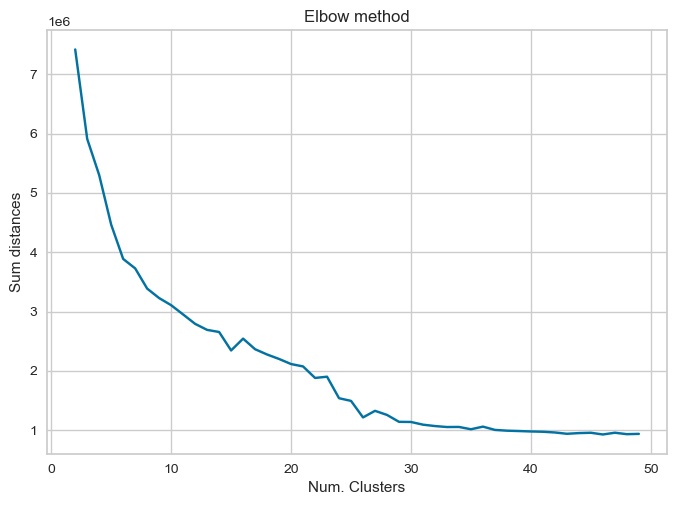

In [215]:
plt.figure()
plt.plot(list(em.keys()), list(em.values()))
plt.xlabel('Num. Clusters')
plt.ylabel('Sum distances')
plt.title('Elbow method')
plt.show()

From this visualization of the `Elbow Method`, we may say the the optimal number of clusters is somewhere between `n=5` and `n=10`. Let us know see what we do obtain from the `InterCluster Distance`.

For the `InterCluster Distance`, we first give some details of its implementation:

Intercluster distance maps shows the cluster centers in 2 dimensions mantaining the distance to other centers. 

The clusters are also sized according to the scoring metric.

**Important**: Note that the fact that two clusters seem to be overlapping in 2D, does not mean that they do in the original feature space.


$ $

In [432]:
from yellowbrick.cluster import intercluster_distance

Notice that if we try to compute the euclidean distance between the obtained centers we fall back into the Elbow method, so we are just going to give a few plots for some values of `n_clusters`.

  0%|                                                    | 0/13 [00:00<?, ?it/s]

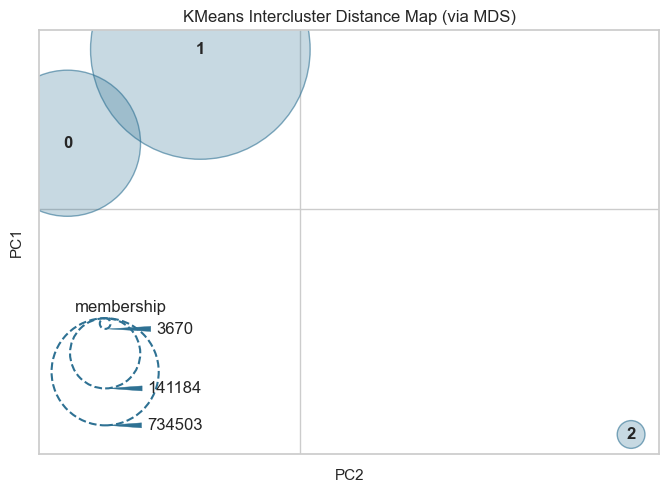

  8%|███▍                                        | 1/13 [00:01<00:20,  1.73s/it]

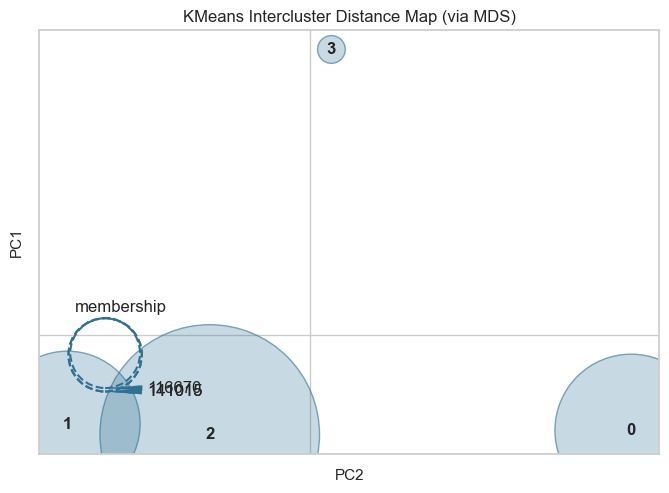

 15%|██████▊                                     | 2/13 [00:04<00:23,  2.17s/it]/Users/ericraguilera/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


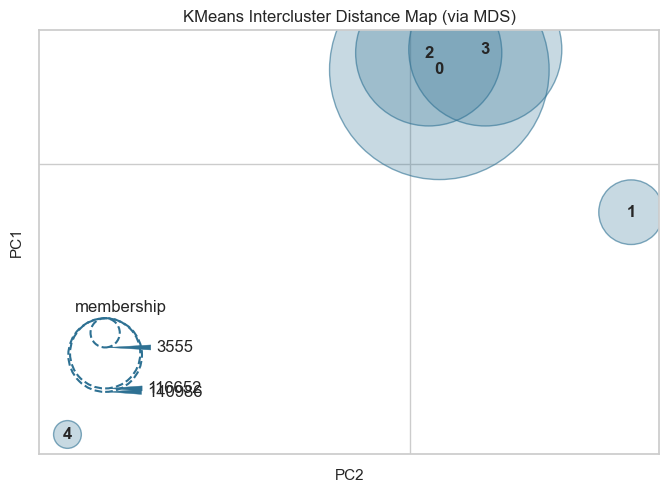

 23%|██████████▏                                 | 3/13 [00:07<00:26,  2.65s/it]

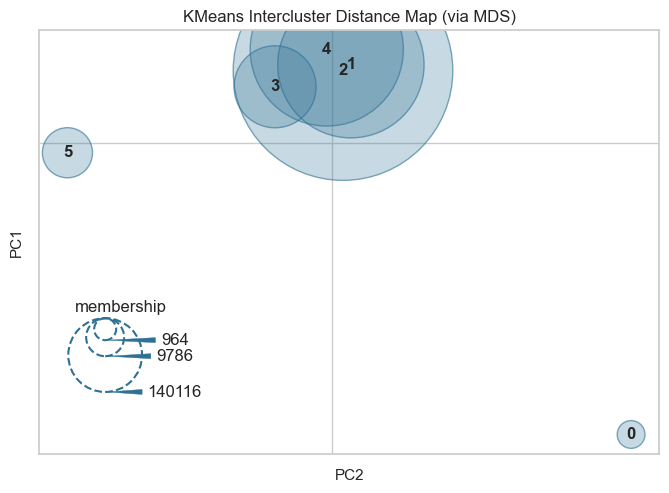

 31%|█████████████▌                              | 4/13 [00:11<00:29,  3.28s/it]

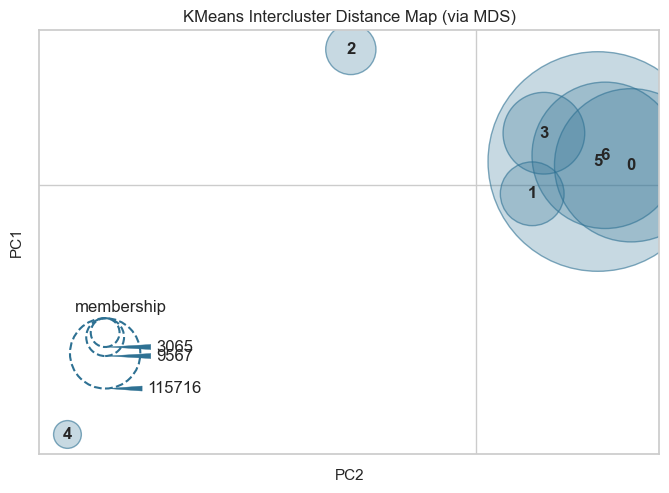

 38%|████████████████▉                           | 5/13 [00:17<00:32,  4.03s/it]

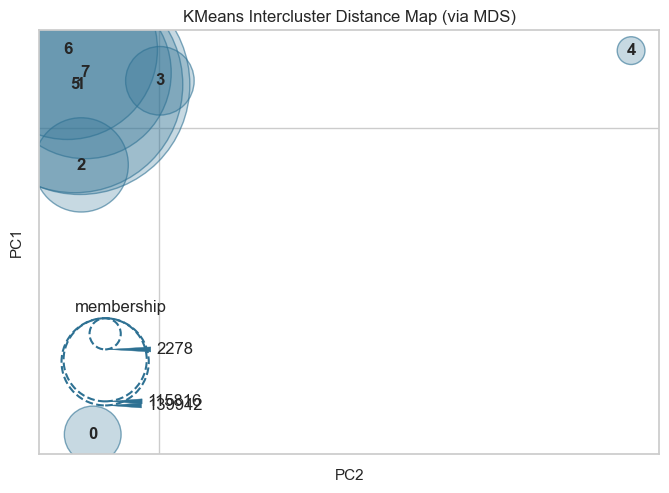

 46%|████████████████████▎                       | 6/13 [00:21<00:29,  4.22s/it]

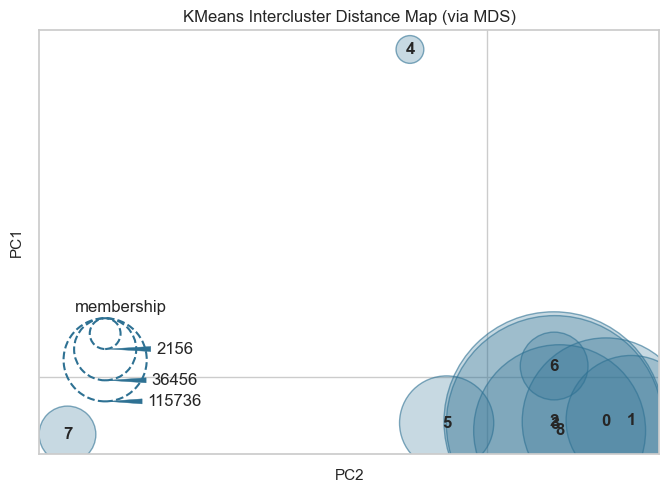

 54%|███████████████████████▋                    | 7/13 [00:27<00:28,  4.76s/it]

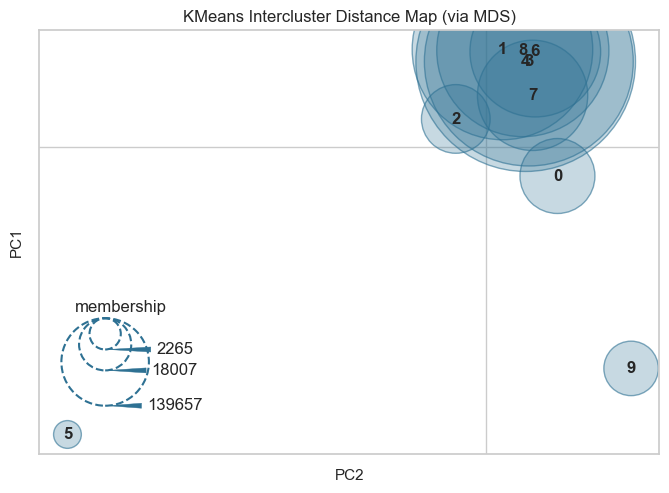

 62%|███████████████████████████                 | 8/13 [00:33<00:25,  5.03s/it]

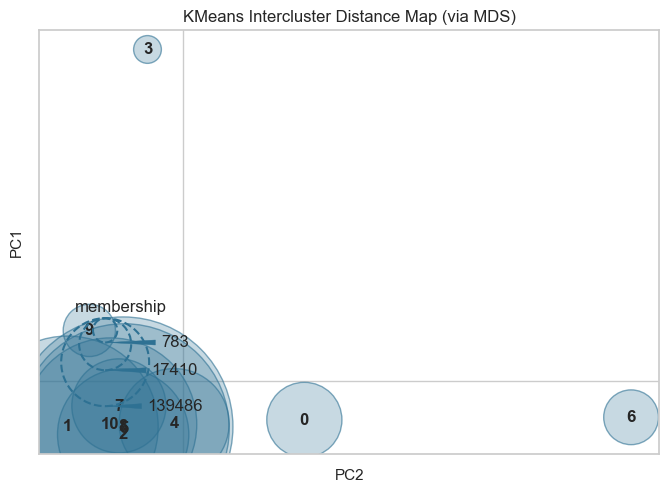

 69%|██████████████████████████████▍             | 9/13 [00:40<00:22,  5.75s/it]

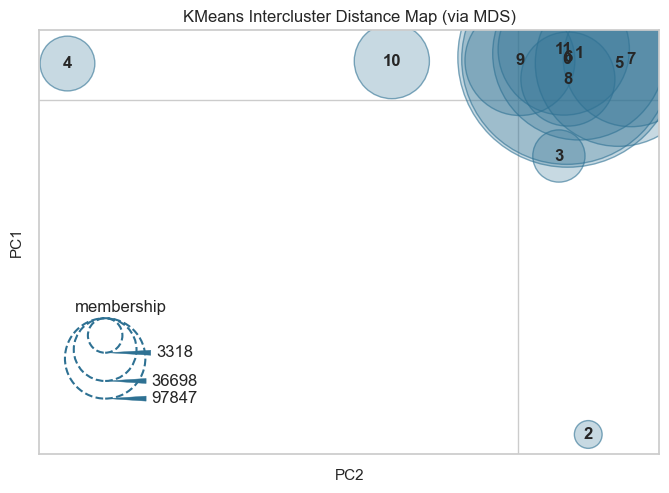

 77%|█████████████████████████████████          | 10/13 [00:48<00:19,  6.37s/it]

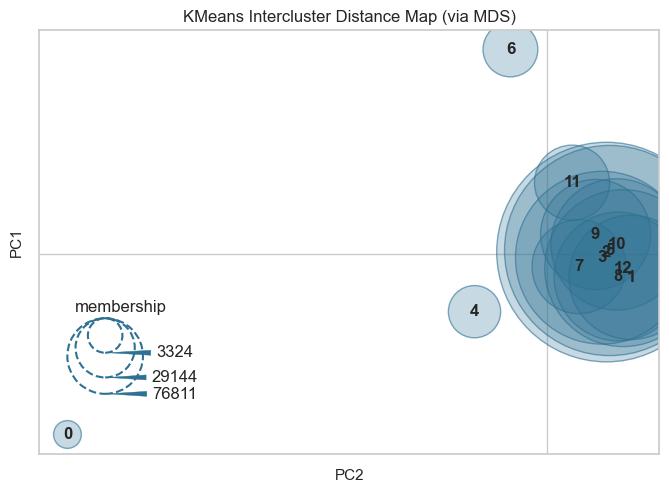

 85%|████████████████████████████████████▍      | 11/13 [00:57<00:14,  7.21s/it]

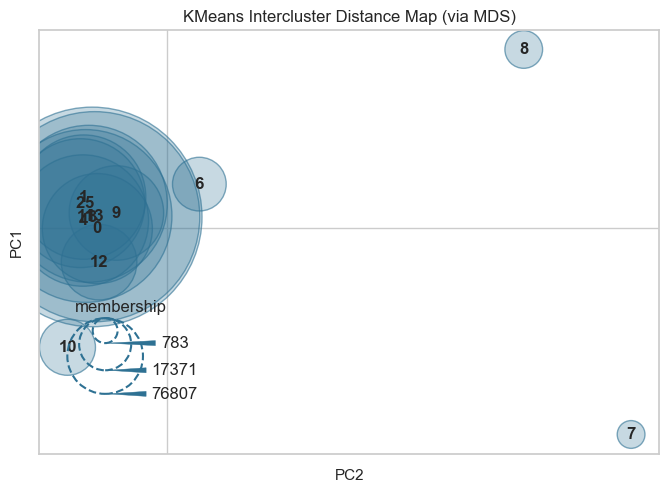

 92%|███████████████████████████████████████▋   | 12/13 [01:06<00:07,  7.85s/it]

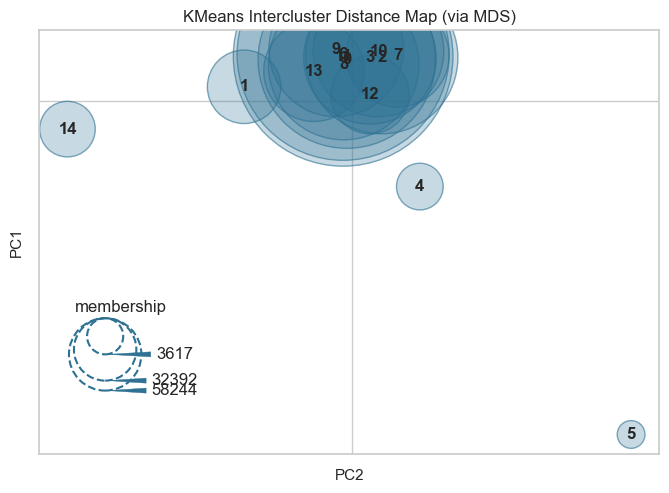

100%|███████████████████████████████████████████| 13/13 [01:17<00:00,  5.93s/it]


In [225]:

for k in tqdm(range(3,16)): 
    model=KMeans(n_clusters=k,init='random')
    intercluster_distance(model,pca_data)


Among these very few plots, we observe that, as expected, as `k` grows, the number of overlaps increases too, but when `k=6`, there are two cluster that are clearly separated, the other do overlap, but we can see clear differences among most of them (notice though that clusters $2$ and $4$ may overlap a lot but, as mentioned before, the overlapping in 2D does not imply anything considering we are working with the 5 features that keep more than $80\%$ of the variance).

Hence, we choose to go with $k=6$.

### 2.3.3.- Run the Algorithm on the Data!

**Observation**

We did try to run our KMeans_MR in EMR and with the pyspark install in our computers but after a few iterations the kernel in both cases stopped and we had to restart all the machinery in EMR or the spark session in our computers.

Hence, we decided to move forward with the `KMeans` algorithm already implemented in `scikit-learn`.

In [147]:
model=KMeans(n_clusters=6,init='random')
result=model.fit(pca_data)


In [148]:
clusters_KMeans=result.labels_

In [412]:
#Here we store the sum of the square distances that we will later compare with the result from K-Means++

dist_KMeans=round(result.inertia_ ,2)

### 2.3.4.- Implement K-Means ++ from `scikit-learn` 

In [150]:
#Here we simply implement the version of K-Means++ in sickit-learn

model_2=KMeans(n_clusters=6,init='k-means++')
model_2.fit(pca_data)

#We also save the sum of the square distances to compare with our other previous result
dist_2=round(model_2.inertia_,2)

And now we compare both results to see which ones is better:

In [151]:
print(f'For the randomized K-Means we get: {dist_KMeans} \n            and for the K-Means++: {dist_2}')

For the randomized K-Means we get: 3886200.05 
            and for the K-Means++: 3753954.87


So, the randomized version is worse than the `KMeans++` one, we observe that moving to the 2nd version the sum of the squared distances decreases around a $3\%$ from the previous implementation.

In [152]:
1-dist_2/dist_KMeans

0.03402943191254393

In [153]:
aux=(model_2.labels_==model.labels_)
aux2=Counter(aux)
print(aux2)
print(f'{aux2[True]/aux2[False]*100}%')

Counter({False: 874002, True: 5355})
0.6126988267761401%


Also, we observe that the cluster where the values are assigned with the `KMeans++` implementation *barely ever* match the ones assigned by the randomized `KMeans`.

In [154]:
#Finally we add a column into the `final_Data` dataframe to assign each data point into its cluster.
final_data['Cluster']=clusters_KMeans+1
final_data.head()

N_Transactions  N_Transaction_100  AverageAmount  Average Balance  \
0               2                  2         2553.0        76340.635   
1               1                  1         1499.0        24204.490   
2               2                  2          727.5       100112.950   
3               1                  1           30.0          496.180   
4               1                  1         5000.0        87058.650   

   Utilisation MostCommonGender MostFreqLocation  MaxTransaction  \
0    73787.635                F          CHENNAI            4750   
1    22705.490                M           MOHALI            1499   
2    99385.450                F            DELHI            1205   
3      466.180                F          GURGAON              30   
4    82058.650                M            DELHI            5000   

   MinTransaction  MostFreqTime  ...  Increment TotalTransactions Num_Cities  \
0             356            12  ...   87679.81              5106          2   
1            1499            20  ...       0.00              1499          1   
2             250            15  ...  123471.62              1455          2   
3              30            17  ...       0.00                30          1   
4            5000            14  ...       0.00              5000          1   

  NightTransactions         0         1         2         3         4 Cluster  
0                 1  4.817054 -0.586794 -0.277843  0.201062  0.247229       1  
1                 0 -0.832107  0.150922 -0.039666  0.378790 -0.134573       4  
2                 1  4.690688 -1.213728 -0.135045  0.637628  0.254586       1  
3                 0 -1.212687 -0.327942 -0.404314 -0.029126  0.239815       4  
4                 0 -0.540078  1.187824  0.083150 -0.502009 -0.181859       4  

[5 rows x 32 columns]

## 2.4.- Analysing your results!

Now we will choose  2-3 variables that we  think are relevant to identify the cluster of the customer.

These will be `Average Balance`,`AverageAmount` and `MinTransaction`.

$ $

To create pivot tables, we choose the given feature and the `cluster` column. After, we use `pivot_table` from pandas, selecting as index the variable we earlier chose and as column the cluster. Finally, we compute the percentage for each column.

In [390]:
chosen_features=final_data[['Average Balance','AverageAmount','MinTransaction','Cluster']]

In [391]:
chosen_features.describe()

Average Balance  AverageAmount  MinTransaction        Cluster
count     8.793570e+05   8.793570e+05    8.793570e+05  879357.000000
mean      1.147151e+05   1.566734e+03    1.374435e+03       3.249200
std       8.010842e+05   6.433249e+03    6.243189e+03       1.189132
min       0.000000e+00   0.000000e+00    0.000000e+00       1.000000
25%       5.591270e+03   1.905000e+02    1.300000e+02       2.000000
50%       1.866578e+04   5.000000e+02    3.750000e+02       4.000000
75%       6.154197e+04   1.241000e+03    1.000000e+03       4.000000
max       1.150355e+08   1.560034e+06    1.560034e+06       6.000000

$ $

Before we do that, we will divide the chosen features into $4$ categories:


### Average Amount Categorisation

First we will go for the `AverageAmount` Feature:

In [393]:
chosen_features['AverageAmount']=pd.qcut(chosen_features.AverageAmount,[0,0.25,0.5,0.75,1],labels=['Low Amount','Medium Amount','Big Amount','Very Big Amount'])

In [230]:
chosen_features.head()

Average Balance AverageAmount  MinTransaction  Cluster
0        76340.635       V Big T             356        1
1        24204.490       V Big T            1499        4
2       100112.950         Big T             250        1
3          496.180         Low T              30        4
4        87058.650       V Big T            5000        4

We have classifies them into 4 categories for the `AverageAmount`:
- **Low Amount**: If the amount of the user is between the minimum and the 1st quartile of the values of this feature.
- **Medium Amount**: If the amount of the user is between the 1st and the 2nd quartile of the values of this feature.
- **Big Amount**: If the amount of the user is between the 2nd and the 3rd quartile of the values of this feature.
- **Very Big Amount**: If the amount of the user is between the 3rd quartile and the maximum value of the values of this feature.

### Min Transaction Categorisation

In [396]:
chosen_features['MinTransaction']=pd.qcut(chosen_features.MinTransaction,[0,0.25,0.5,0.75,1],labels=['Little T','Hundreds T','Thousand T','Big T'])

In [395]:
chosen_features.head()

Average Balance    AverageAmount MinTransaction  Cluster
0        76340.635  Very Big Amount     Hundreds T        1
1        24204.490  Very Big Amount          Big T        4
2       100112.950       Big Amount     Hundreds T        1
3          496.180       Low Amount       Little T        4
4        87058.650  Very Big Amount          Big T        4

We have classifies them into 4 categories for the `MaxTransaction`:
- **Little T**: Max T that are below the 1st quartile

- **Hunderds T**: Max T that are between the 1st and the 2nd quartile (a few hunderds of the currency, that is the reason for the name).

- **Thousand T**: Max T that are between the 2nd and the 3rd quartile (around 1000 of the currency, that is the reason for the name).

- **Big T**: Max T that are above the 3rd quartile.

### Average Balance Categorisation

In [398]:
chosen_features['Average Balance']=pd.qcut(chosen_features['Average Balance'],[0,0.25,0.5,0.75,1],labels=['Few Thousands Balance',' 10 Thousands Balance','50 Thousands Balance','Higher Balance'])

We have classifies them into 4 categories for the `LogCustAccountBalance`:

- **Few Thousands Balance**: Avg. Balance below 10.000 currency units.

- **10 Thousands Balance**: Avg. Balance around 10.000-15.000 currency units.

- **50 Thousands Balance**: Avg. Balance above 16.000 and below 60.000 currency units.

- **Higher Balance**: Avg. Balance above 60.000 currency units.

Hence, we end up with the following features in a DataFrame to compute the pivot tables.

In [399]:
chosen_features

Average Balance    AverageAmount MinTransaction  Cluster
0              Higher Balance  Very Big Amount     Hundreds T        1
1        50 Thousands Balance  Very Big Amount          Big T        4
2              Higher Balance       Big Amount     Hundreds T        1
3       Few Thousands Balance       Low Amount       Little T        4
4              Higher Balance  Very Big Amount          Big T        4
...                       ...              ...            ...      ...
879352   10 Thousands Balance       Big Amount     Thousand T        4
879353         Higher Balance       Big Amount     Thousand T        4
879354         Higher Balance    Medium Amount     Hundreds T        4
879355  Few Thousands Balance       Low Amount       Little T        4
879356   50 Thousands Balance       Low Amount       Little T        2

[879357 rows x 4 columns]

#### Pivot 1:   Average Amount

In [405]:
pivot_amount = chosen_features[['AverageAmount','Cluster']]

pivot_amount = pd.pivot_table(data=pivot_amount, index='Cluster', columns='AverageAmount', 
                              aggfunc=len,fill_value=0,margins=True,margins_name='Sum')

pivot1 = round(pivot_amount.div( pivot_amount.iloc[:,-1], axis=0)*100,2)


In [406]:
pivot1

AverageAmount  Low Amount  Medium Amount  Big Amount  Very Big Amount    Sum
Cluster                                                                     
1                   13.68          26.32       31.98            28.03  100.0
2                   27.19          28.84       22.27            21.70  100.0
3                    0.00           0.00        0.01            99.99  100.0
4                   27.62          27.54       21.24            23.60  100.0
5                   10.79           8.63        8.63            71.94  100.0
6                    0.00           0.00        0.00           100.00  100.0
Sum                 25.00          27.18       22.83            24.99  100.0

When we focus our study on this feature, `Average Amount`, we notice that:
- Observe that in clusters $1,2$ and $4$ the number of customers that fall into the category of `V Big T` is pretty similar and much smaller than in clusters $3,5,6$. In fact, in $5$ it is a bit lass than $75\%$ but in $3$ and $6$ it essentially is the whole set of customers in that clustes.
- Overall, the percentage of each class within cluste $2$ and $4$ is very uniform. As for cluster $5$, $10\%$ of the population is in the `Low Amount` class and the remaining $16\%$ is equally distributed among the remaining classes.

#### Pivot 2:  MinTransaction

In [408]:
pivot_min = chosen_features[['MinTransaction','Cluster']]

pivot_min = pd.pivot_table(data=pivot_min, index='Cluster', columns='MinTransaction', 
                              aggfunc=len,fill_value=0,margins=True,margins_name='Sum')

pivot2 = round(pivot_min.div(pivot_min.iloc[:,-1], axis=0)*100,2)
pivot2.drop('Sum',inplace=True)

In [409]:
pivot2

MinTransaction  Little T  Hundreds T  Thousand T  Big T    Sum
Cluster                                                       
1                  41.16       31.50       20.42   6.92  100.0
2                  21.43       25.45       27.10  26.01  100.0
3                   3.60        3.02        3.41  89.97  100.0
4                  22.38       23.84       26.21  27.58  100.0
5                  13.67       14.39        7.91  64.03  100.0
6                   1.35        1.97        0.93  95.75  100.0

When we focus our study on this feature, `Min Transaction`, we notice that:
- In clusters $3$ and $6$, at least around a $90\%$ of the population fall into the class of `Big T`.
- On the contrary, in cluster $1$, almost half of the population is in `Little T`, around a third is in `Hundreds T` and there is slightly more than a $5\%$ in the `Big T` class.
- Notice that both clusters $2$ and $4$ distribute uniformly over the classes of this feature. To state some really non-remarkable differences, in the classes `Little T` and `Big T`, there is a little more percentage in cluster $4$ than in $2$ and opposite for the other 2 classes.

#### Pivot 3 : Average Balance

In [410]:
pivot_b = chosen_features[['Average Balance','Cluster']]

pivot_b = pd.pivot_table(data=pivot_b, index='Cluster', columns='Average Balance', 
                              aggfunc=len,fill_value=0,margins=True,margins_name='Sum')

pivot3 = round(pivot_b.div(pivot_b.iloc[:,-1], axis=0)*100,2)

pivot3.drop('Sum',inplace=True)

In [411]:
pivot3

Average Balance  Few Thousands Balance   10 Thousands Balance  \
Cluster                                                         
1                                11.70                  25.89   
2                                28.22                  25.52   
3                                11.15                  12.28   
4                                27.69                  24.93   
5                                 0.00                   0.00   
6                                 5.29                   8.61   

Average Balance  50 Thousands Balance  Higher Balance    Sum  
Cluster                                                       
1                               31.47           30.94  100.0  
2                               24.11           22.15  100.0  
3                               23.10           53.46  100.0  
4                               23.74           23.63  100.0  
5                                0.00          100.00  100.0  
6                               11.41           74.69  100.0

When we focus our study on this feature, `Average Balance`, we notice that:
- As we have seen when looking to the other features, the distribution of clusters $2$ and $4$ is very similar and uniform along the classes.
- All of the customer that are in cluster $5$ fall into the `Higher Balance` class.
- $75\%$ of the customer in cluster $6$ are in `Higher Balance` class, a bit more than $10\%$ in `50 Thousand Balance`, around a $5\%$ in `Few Thousands` and the rest in he remaining class. A similar distributions happens within cluster $3$ but with with a more balanced concentration among all the classes. 
- Finally, the percentage of customers in cluster $1$ that are in the classes of `10 Thousands Balance` and `50 Thousands Balance` is the greatest among the rest, separately, and being around a $30\%$ and $26\%$ respectively. The percentage of customer in class `10 Thousands Balance` is approximately $25\%$ in clusters $1,2$ and $4$.  


### Cluster's Score

As we have already implemented previously, in the variable `result` we have al the information regarding our implementation:

In [419]:
print(f'The algorithm did {result.n_iter_} iterations until it converged.')

The algorithm did 28 iterations until it converged.


In [430]:
print(f'The algorithm provides centroids and clusters such that the sum of squared distance from the each data point to the centroid of the cluster where it belongs to is {round(result.inertia_,2)}, measured with euclidean distance.')

The algorithm provides centroids and clusters such that the sum of squared distance from the each data point to the centroid of the cluster where it belongs to is 3886200.05, measured with euclidean distance.


# Command Line Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tools that you know to answer the following questions using the same dataset that you have been using so far:

1. Which location has the maximum number of purchases been made?
2. In the dataset provided, did females spend more than males, or vice versa?
3. Report the customer with the highest average transaction amount in the dataset.

**Note**: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

In [39]:
sh = """
# We check if the the .cvs file exists, otherwise we donwload it

if [ ! -f bank_transactions.csv ]; then

  echo 'Downloading the file:'

  # Donwload the zip file from the S3 Bucket
  wget https://adm-hw4-mep27.s3.amazonaws.com/bank_segmentation.zip

  # Unzip the zip file
  unzip -q bank_segmentation.zip

  # Remove the zip file
  rm bank_segmentation.zip

fi  

# Visualize the dataset head
echo 'Visualize the dataset head'
head bank_transactions.csv
echo '---------------------------------------------------------------------------'

# Question 1
echo 'Question 1) First 10 locations with maximum number of purchases:'
awk -F ',' '{print $5}' bank_transactions.csv | sort | uniq -c | sort -nr | head -10
echo '---------------------------------------------------------------------------'

# Question 2
echo 'Question 2) In the dataset provided, did females spend more than males, or vice versa?'

echo 'Females purchases AVG: '
awk -F ',' '$4=="F"{sum+=$9;cnt++}END{print sum/cnt}' bank_transactions.csv
echo 'Females purchases SUM: '
awk -F ',' '$4=="F"{sum+=$9}END{print sum}' bank_transactions.csv

echo 'Males purchases AVG: '
awk -F ',' '$4=="M"{sum+=$9;cnt++}END{print sum/cnt}' bank_transactions.csv
echo 'Males purchases SUM: '
awk -F ',' '$4=="M"{sum+=$9}END{print sum}' bank_transactions.csv

echo 'yes, did females spend more than males'
echo '---------------------------------------------------------------------------'

# Question 3
echo 'Question 3) Customer with the highest average transaction amount in the dataset: '
awk -F ',' '{seen[$2]+=$9; count[$2]++} END{for (x in seen)print  seen[x]/count[x],x}' bank_transactions.csv | sort -nr | head -n 1

wait
"""
with open('CommandLine.sh', 'w') as script:
  script.write(sh)

We make `CommandLine.sh` executable:

In [40]:
os.system("chmod +x CommandLine.sh")

0

We run the shell script with:

In [41]:
print(os.popen('./CommandLine.sh').read())

Visualize the dataset head
TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25
T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999
T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459
T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060
T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
T6,C1536588,8/10/72,F,ITANAGAR,53609.2,2/8/16,173940,676
T7,C7126560,26/1/92,F,MUMBAI,973.46,2/8/16,173806,566
T8,C1220223,27/1/82,M,MUMBAI,95075.54,2/8/16,170537,148
T9,C8536061,19/4/88,F,GURGAON,14906.96,2/8/16,192825,833
---------------------------------------------------------------------------
Question 1) First 10 locations with maximum number of purchases:
 103595 MUMBAI
  84928 NEW DELHI
  81555 BANGALORE
  73818 GURGAON
  71019 DELHI
  32784 NOIDA
  30009 CHENNAI
  25851 PUNE
  23049 HYDERABAD
  21505 THANE
----------------------

# Algorithmic Question

An idea to solve this question is to get the interval of entrance for each door and then analyze those intervals to check the maximum number of intervals overlapping with each other.

To get the intervals we scan the entrances list and save in a dictionary for each value two indexes:
- The index of its the first occurence.
- The index of its last occurence.

So at the end of this process we have a dictionary of this type:



```python
intervales = {door_1: [first_occurrence_1, last_occurence_1],
              door_2: [first_occurrence_2, last_occurence_2],
              ...,
              door_n: [first_occurrence_n, last_occurence_n]}
```

**Note**: `len(intervales) < n` because students are not bound to use all the doors.

Then use the entrances order as time series, so for each entrance index we check how many intervals are open and we save the maximum value.

Now we have just to compare this maximum to the value of `g`:
- If `maximum <= g` then we return "YES".
- Else we return "NO".

## Algorithm Complexity

There are two main steps:

- Generating the intervals dictionary.
- Check the maximum overlap.

### Generating the intervals dictionary

- We have to scan the entrances array which has length equal to $m$
- Then we control if the entrance is in the intervals keys or not: this control takes in the worst case $j$ steps, where $j$ is the length of the dictionary when the control is taken.

So:

$$
\text{cost} = \sum_{i=1}^m j_i
$$

Considering that the value of an entrance corresponds to a door number, we know that $j_i \le n\ \forall i \in [0,m]$. So we can bound this value by considering a full intervals array of $n$ elements:

$$
 \text{cost} = \sum_{i=1}^m j_i < \sum_{i=1}^m n = m\cdot n
$$

This step has as complexity $O(m\cdot n)$.

### Check the maximum overlap

- For each entrance index we initialize a value to 0 and then...
- For each interval we do a comparison.

This step have exactly complexity $O(m\cdot n)$.

### The overall complexity

The overall complexity is the sum of those two steps complexity:

$$
O(m\cdot n) + O(m\cdot n) = 2 O(m\cdot n) = O(m\cdot n)
$$

So the algorithm complexity is equal to $O(m\cdot n)$.



In [50]:
def check_guards() -> str:
  """A function that take as input a number of doors, a number of students,
  a number of guards and an order of entrances, checks if the guards are enough or not.

  Args:
    - None

  Returns:
    - str : "YES" if the number of guards is enough, "NO" otherwise.

  Usage:
    - First input: Insert as a string the values for n, m and g (doors, students and guards)
                   separeted by a space. Example "1 5 2".
    - Second input: Insert as a string the order of entrances. Example "1 1 2 1 1 1".
  """
  n, m, g = tuple(map(int, input("Insert number of doors, students and guards separeted by a space.\n").split()))

  entrances = list(map(int, input("Insert an order of entrance.\n").split()))

  assert m == len(entrances), "Error: got different number of entrances than number of students."

  intervals = {}

  for i, entrance in enumerate(entrances):
    if entrance not in intervals:
      assert entrance <= n, f"Error: got an entrance bigger than the maximum entrance code possible."
      intervals[entrance] = [i, i]
    else:
      intervals[entrance][1] = i

  maximum = 0

  for i in range(len(entrances)):
    value = 0
    for interval in intervals:
      if i >= intervals[interval][0] and i <= intervals[interval][1]:
        value += 1

    if value > maximum:
      maximum = value

  return "YES" if maximum <= g else "NO"

In [46]:
check_guards()

Insert number of doors, students and guards separeted by a space.
4 5 1
Insert an order of entrance.
1 1 3 3 3 


'YES'

In [48]:
check_guards()

Insert number of doors, students and guards separeted by a space.
2 5 1
Insert an order of entrance.
1 2 1 2 2


'NO'